# Inception V4 Pretrained Model (timm)

`timm` 라이브러리를 사용하여 ImageNet으로 pretrain된 순수 Inception V4 모델을 불러와서 운전자 행동 분류를 수행합니다.

# Import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import KFold

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 디바이스: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

사용 디바이스: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


# Data Load

In [6]:
# 하이퍼파라미터
img_size = 299  # Inception V4 입력 크기
batch_size = 32
num_classes = 10
num_epochs = 50
learning_rate = 0.001
num_workers = 0
version = "0.0"

# 데이터 경로
base_dir = r'c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj'
driver_csv_path = os.path.join(base_dir, 'data', 'driver_imgs_list.csv')
train_dir = os.path.join(base_dir, 'data', 'imgs', 'train')
test_dir = os.path.join(base_dir, 'data', 'imgs', 'test')
best_model_path = f'models/inception_v{version}.pth'

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")
print(f"이미지 크기: {img_size}x{img_size}")
print(f"배치 크기: {batch_size}")

Train directory: c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj\data\imgs\train
Test directory: c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj\data\imgs\test
이미지 크기: 299x299
배치 크기: 32


고유 운전자 수: 26명
운전자 목록: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


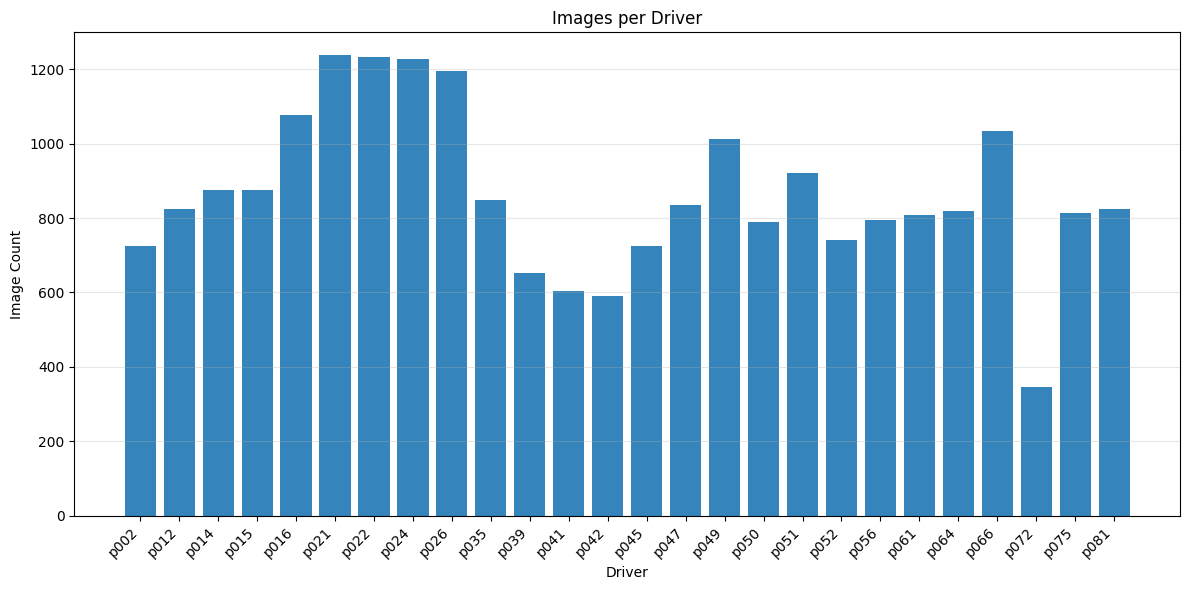

In [11]:
driver_df = pd.read_csv(driver_csv_path)

print(f"고유 운전자 수: {driver_df['subject'].nunique()}명")
print(f"운전자 목록: {sorted(driver_df['subject'].unique())}")

driver_counts = driver_df['subject'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(driver_counts.index.astype(str), driver_counts.values, color='C0', alpha=0.9)
plt.xlabel('Driver')
plt.ylabel('Image Count')
plt.title('Images per Driver')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 5-Fold Cross Validation
fold별 운전자 목록을 미리 나누긴 하되 초기 실험 단계에서는 한 폴드(fold 2, 학습 데이터가 가장 많아서..)만 사용하고 이후 마무리 단계에서 전체 폴드 다 돌려서 일반화 성능 끌어올리는 방향으로 진행.

## split train data into 5 folds

In [13]:
all_drivers = sorted(driver_df['subject'].unique())

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_splits = []
for fold_idx, (train_indices, val_indices) in enumerate(kfold.split(all_drivers)):
	train_drivers = [all_drivers[i] for i in train_indices]
	val_drivers = [all_drivers[i] for i in val_indices]

	fold_splits.append({
		'fold': fold_idx+1,
		'train_drivers': train_drivers,
		'val_drivers': val_drivers
	})

	print("Fold", fold_idx+1)
	print("train:", train_drivers, "val:", val_drivers)
	
	train_imgs = driver_df[driver_df['subject'].isin(train_drivers)]
	val_imgs = driver_df[driver_df['subject'].isin(val_drivers)]
	print(f"학습 이미지: {len(train_imgs)}개")
	print(f"검증 이미지: {len(val_imgs)}개")

Fold 1
train: ['p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p039', 'p042', 'p045', 'p047', 'p049', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p081'] val: ['p002', 'p026', 'p035', 'p041', 'p050', 'p075']
학습 이미지: 17446개
검증 이미지: 4978개
Fold 2
train: ['p002', 'p015', 'p016', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p075', 'p081'] val: ['p012', 'p014', 'p021', 'p045', 'p072']
학습 이미지: 18418개
검증 이미지: 4006개
Fold 3
train: ['p002', 'p012', 'p014', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p045', 'p047', 'p050', 'p051', 'p052', 'p056', 'p061', 'p066', 'p072', 'p075', 'p081'] val: ['p015', 'p016', 'p042', 'p049', 'p064']
학습 이미지: 18049개
검증 이미지: 4375개
Fold 4
train: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p056', 'p064', 'p072', 'p075'] val: ['p051', 'p052', 'p061', 'p066', 'p081

## define DraiverDataset

In [14]:
class DriverDataset(Dataset):
    """운전자 행동 데이터셋"""
    
    def __init__(self, data_dir, driver_df, driver_list, transform=None, is_test=False):
        self.data_dir = data_dir
        self.transform = transform
        self.is_test = is_test
        self.images = []
        self.labels = []
        
        if is_test:
            test_images_dir = data_dir
            for img_name in os.listdir(test_images_dir):
                self.images.append(os.path.join(test_images_dir, img_name))
        else: #is_train
            driver_subset = driver_df[driver_df['subject'].isin(driver_list)]

            for _, row in driver_subset.iterrows():
                class_name = row['classname']
                img_name = row['img']
                img_path = os.path.join(data_dir, class_name, img_name)

                self.images.append(img_path)
                class_idx = int(class_name[1:])
                self.labels.append(class_idx)
        print(f"{'테스트' if is_test else '운전자' + str(len(driver_list))+'명'}, 데이터 {len(self.images)}개 이미지")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, os.path.basename(img_path)
        else:
            label = self.labels[idx]
            return image, label

## define team transform

In [15]:
team_transform_train = transforms.Compose([
	transforms.Resize((img_size, img_size)),
	transforms.RandomRotation(degrees=15),
	transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),

	transforms.ToTensor(),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

team_transform_eval = transforms.Compose([
	transforms.Resize((img_size, img_size)),
	transforms.ToTensor(),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

## train

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    한 에폭(Epoch) 동안 모델을 학습시키고 손실과 정확도를 반환합니다.
    """
    model.train()  # 모델을 학습 모드로 설정
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # 훈련 데이터셋의 모든 배치를 반복합니다.
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 그래디언트 초기화
        optimizer.zero_grad()
        
        # 순전파 (Forward pass)
        outputs = model(inputs)
        loss = criterion(outputs, labels) # Log Loss (CrossEntropyLoss) 계산
        
        # 역전파 및 최적화 (Backward pass and optimization)
        loss.backward()
        optimizer.step()
        
        # 통계 업데이트
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
        
    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples) * 100
    
    return epoch_loss, epoch_acc.item()

In [8]:
def validate(model, val_loader, criterion, device):
    """
    검증 데이터셋을 이용해 모델의 성능(손실과 정확도)을 평가하고 반환합니다.
    """
    model.eval()  # 모델을 평가 모드로 설정
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # 그래디언트 계산을 비활성화합니다.
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Log Loss (CrossEntropyLoss) 계산
            
            # 통계 업데이트
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples) * 100
    
    # epoch_loss가 Log Loss에 해당하며, 이 값을 기준으로 최고 성능 모델을 저장합니다.
    return epoch_loss, epoch_acc.item()

In [3]:
def train_fold(fold_idx, train_drivers, val_drivers):
    """한 폴드 학습 (Log Loss 기준)"""

    print(f"\n========== Fold {fold_idx}/{n_folds} ==========")

    train_dataset = DriverDataset(
        train_dir, driver_df, train_drivers,
        transform=team_transform_train, is_test=False
    )

    val_dataset = DriverDataset(
        train_dir, driver_df, val_drivers,
        transform=team_transform_eval, is_test=False
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    print(f"학습 배치 수: {len(train_loader)}")
    print(f"검증 배치 수: {len(val_loader)}")

    model = timm.create_model(
        'inception_v4',
        pretrained=True,
        num_classes = num_classes
    )
    model = model.to(device)

    # Log Loss 사용을 위해 criterion은 그대로 CrossEntropyLoss를 사용합니다.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-4)
    
    # mode='min'으로 설정하여 Log Loss 최소화를 목표로 합니다.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=7
    )

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # 최고 검증 손실 추적
    best_val_loss = float('inf') 
    best_model_path = f'models/inception_v{version}'

    # 에폭 학습
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 70)
        
        # 학습
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # 검증 (val_loss가 Log Loss에 해당)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # 히스토리 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 결과 출력
        print(f'\n📊 Epoch {epoch+1} 결과:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
        
        # 검증 손실을 기준으로 스케줄러 step
        scheduler.step(val_loss)
        
        # 최고 성능 모델 저장: 검증 손실(val_loss)이 낮아질 때 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'fold': fold_idx,
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc, # 참고용으로 val_acc도 저장
                'history': history
            }, best_model_path)
            print(f'  ✓ 최고 성능 모델 저장! (Val Loss: {val_loss:.4f})')
            
    print(f"\n✓ Fold {fold_idx} 학습 완료! 최저 검증 손실: {best_val_loss:.4f}")

    return {
        'fold': fold_idx,
        'history': history,
        'best_val_loss': best_val_loss,
        'best_val_acc': max(history['val_acc']),
        'model_path': best_model_path
    }

In [17]:
all_fold_results = []

fold_info = fold_splits[1] 

fold_idx = fold_info['fold']
train_drivers = fold_info['train_drivers']
val_drivers = fold_info['val_drivers']
    
# 폴드 학습
fold_result = train_fold(fold_idx, train_drivers, val_drivers)
all_fold_results.append(fold_result)
    
# 메모리 정리
torch.cuda.empty_cache()

# 결과 출력: Log Loss를 기준으로 학습했으므로 Loss를 출력하는 것이 적절합니다.
print(f"  Fold {fold_result['fold']}: 최저 Val Loss: {fold_result['best_val_loss']:.4f} | 최고 Val Acc: {fold_result['best_val_acc']:.2f}%")


========== Fold 2/5 ==========
운전자21명, 데이터 18418개 이미지
운전자5명, 데이터 4006개 이미지
학습 배치 수: 576
검증 배치 수: 126

Epoch 1/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:42<00:00,  2.98it/s]



📊 Epoch 1 결과:
  Train Loss: 0.3300 | Train Acc: 90.03%
  Val Loss:   5.3076 | Val Acc:   42.59%
  ✓ 최고 성능 모델 저장! (Val Loss: 5.3076)

Epoch 2/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:40<00:00,  3.12it/s]



📊 Epoch 2 결과:
  Train Loss: 0.1364 | Train Acc: 96.10%
  Val Loss:   0.8470 | Val Acc:   80.75%
  ✓ 최고 성능 모델 저장! (Val Loss: 0.8470)

Epoch 3/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:38<00:00,  3.31it/s]



📊 Epoch 3 결과:
  Train Loss: 0.1112 | Train Acc: 96.83%
  Val Loss:   0.7220 | Val Acc:   81.83%
  ✓ 최고 성능 모델 저장! (Val Loss: 0.7220)

Epoch 4/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:38<00:00,  3.27it/s]



📊 Epoch 4 결과:
  Train Loss: 0.0984 | Train Acc: 97.35%
  Val Loss:   0.5230 | Val Acc:   83.65%
  ✓ 최고 성능 모델 저장! (Val Loss: 0.5230)

Epoch 5/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:37<00:00,  3.32it/s]



📊 Epoch 5 결과:
  Train Loss: 0.0808 | Train Acc: 97.69%
  Val Loss:   0.6105 | Val Acc:   86.45%

Epoch 6/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.47it/s]



📊 Epoch 6 결과:
  Train Loss: 0.0924 | Train Acc: 97.28%
  Val Loss:   0.6542 | Val Acc:   82.55%

Epoch 7/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 7 결과:
  Train Loss: 0.0746 | Train Acc: 97.99%
  Val Loss:   0.6396 | Val Acc:   85.42%

Epoch 8/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.51it/s]



📊 Epoch 8 결과:
  Train Loss: 0.0757 | Train Acc: 97.84%
  Val Loss:   1.7192 | Val Acc:   61.68%

Epoch 9/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 9 결과:
  Train Loss: 0.0652 | Train Acc: 98.16%
  Val Loss:   1.0030 | Val Acc:   77.91%

Epoch 10/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.50it/s]



📊 Epoch 10 결과:
  Train Loss: 0.0663 | Train Acc: 98.11%
  Val Loss:   0.6606 | Val Acc:   86.05%

Epoch 11/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.49it/s]



📊 Epoch 11 결과:
  Train Loss: 0.0598 | Train Acc: 98.33%
  Val Loss:   0.6737 | Val Acc:   81.30%

Epoch 12/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 12 결과:
  Train Loss: 0.0604 | Train Acc: 98.28%
  Val Loss:   0.7716 | Val Acc:   80.65%

Epoch 13/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 13 결과:
  Train Loss: 0.0255 | Train Acc: 99.36%
  Val Loss:   0.5691 | Val Acc:   86.22%

Epoch 14/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.46it/s]



📊 Epoch 14 결과:
  Train Loss: 0.0182 | Train Acc: 99.50%
  Val Loss:   0.7902 | Val Acc:   82.80%

Epoch 15/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.47it/s]



📊 Epoch 15 결과:
  Train Loss: 0.0273 | Train Acc: 99.21%
  Val Loss:   0.6289 | Val Acc:   84.87%

Epoch 16/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.47it/s]



📊 Epoch 16 결과:
  Train Loss: 0.0222 | Train Acc: 99.36%
  Val Loss:   0.8248 | Val Acc:   83.95%

Epoch 17/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.46it/s]



📊 Epoch 17 결과:
  Train Loss: 0.0280 | Train Acc: 99.26%
  Val Loss:   0.5643 | Val Acc:   83.60%

Epoch 18/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.50it/s]



📊 Epoch 18 결과:
  Train Loss: 0.0261 | Train Acc: 99.26%
  Val Loss:   0.6356 | Val Acc:   83.42%

Epoch 19/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.47it/s]



📊 Epoch 19 결과:
  Train Loss: 0.0205 | Train Acc: 99.43%
  Val Loss:   0.6042 | Val Acc:   86.62%

Epoch 20/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.49it/s]



📊 Epoch 20 결과:
  Train Loss: 0.0206 | Train Acc: 99.42%
  Val Loss:   0.6732 | Val Acc:   85.77%

Epoch 21/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.50it/s]



📊 Epoch 21 결과:
  Train Loss: 0.0083 | Train Acc: 99.79%
  Val Loss:   0.5948 | Val Acc:   87.09%

Epoch 22/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 22 결과:
  Train Loss: 0.0069 | Train Acc: 99.80%
  Val Loss:   0.5777 | Val Acc:   87.64%

Epoch 23/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.44it/s]



📊 Epoch 23 결과:
  Train Loss: 0.0107 | Train Acc: 99.73%
  Val Loss:   0.5545 | Val Acc:   88.04%

Epoch 24/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 24 결과:
  Train Loss: 0.0082 | Train Acc: 99.80%
  Val Loss:   0.6523 | Val Acc:   86.97%

Epoch 25/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 25 결과:
  Train Loss: 0.0096 | Train Acc: 99.72%
  Val Loss:   0.7943 | Val Acc:   85.72%

Epoch 26/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.41it/s]



📊 Epoch 26 결과:
  Train Loss: 0.0059 | Train Acc: 99.85%
  Val Loss:   0.6631 | Val Acc:   84.52%

Epoch 27/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 27 결과:
  Train Loss: 0.0047 | Train Acc: 99.87%
  Val Loss:   0.5247 | Val Acc:   87.24%

Epoch 28/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 28 결과:
  Train Loss: 0.0065 | Train Acc: 99.85%
  Val Loss:   0.7247 | Val Acc:   84.77%

Epoch 29/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.47it/s]



📊 Epoch 29 결과:
  Train Loss: 0.0033 | Train Acc: 99.91%
  Val Loss:   0.6623 | Val Acc:   86.87%

Epoch 30/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.50it/s]



📊 Epoch 30 결과:
  Train Loss: 0.0025 | Train Acc: 99.94%
  Val Loss:   0.6270 | Val Acc:   86.22%

Epoch 31/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.51it/s]



📊 Epoch 31 결과:
  Train Loss: 0.0017 | Train Acc: 99.99%
  Val Loss:   0.6698 | Val Acc:   86.17%

Epoch 32/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:37<00:00,  3.39it/s]



📊 Epoch 32 결과:
  Train Loss: 0.0042 | Train Acc: 99.92%
  Val Loss:   0.5960 | Val Acc:   86.72%

Epoch 33/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 33 결과:
  Train Loss: 0.0019 | Train Acc: 99.98%
  Val Loss:   0.6178 | Val Acc:   87.54%

Epoch 34/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.51it/s]



📊 Epoch 34 결과:
  Train Loss: 0.0017 | Train Acc: 99.98%
  Val Loss:   0.5515 | Val Acc:   87.49%

Epoch 35/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 35 결과:
  Train Loss: 0.0052 | Train Acc: 99.88%
  Val Loss:   0.6221 | Val Acc:   89.14%

Epoch 36/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.44it/s]



📊 Epoch 36 결과:
  Train Loss: 0.0060 | Train Acc: 99.87%
  Val Loss:   0.6664 | Val Acc:   84.65%

Epoch 37/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:37<00:00,  3.39it/s]



📊 Epoch 37 결과:
  Train Loss: 0.0020 | Train Acc: 99.98%
  Val Loss:   0.6425 | Val Acc:   85.52%

Epoch 38/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.42it/s]



📊 Epoch 38 결과:
  Train Loss: 0.0012 | Train Acc: 99.99%
  Val Loss:   0.5811 | Val Acc:   87.77%

Epoch 39/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.49it/s]



📊 Epoch 39 결과:
  Train Loss: 0.0014 | Train Acc: 99.99%
  Val Loss:   0.5576 | Val Acc:   87.64%

Epoch 40/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.49it/s]



📊 Epoch 40 결과:
  Train Loss: 0.0020 | Train Acc: 99.96%
  Val Loss:   0.6357 | Val Acc:   86.94%

Epoch 41/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.44it/s]



📊 Epoch 41 결과:
  Train Loss: 0.0017 | Train Acc: 99.97%
  Val Loss:   0.6596 | Val Acc:   87.19%

Epoch 42/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 42 결과:
  Train Loss: 0.0014 | Train Acc: 99.98%
  Val Loss:   0.5804 | Val Acc:   87.47%

Epoch 43/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 43 결과:
  Train Loss: 0.0019 | Train Acc: 99.98%
  Val Loss:   0.6036 | Val Acc:   87.72%

Epoch 44/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:38<00:00,  3.26it/s]



📊 Epoch 44 결과:
  Train Loss: 0.0011 | Train Acc: 99.99%
  Val Loss:   0.5516 | Val Acc:   88.29%

Epoch 45/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:40<00:00,  3.11it/s]



📊 Epoch 45 결과:
  Train Loss: 0.0013 | Train Acc: 99.99%
  Val Loss:   0.5716 | Val Acc:   88.42%

Epoch 46/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:40<00:00,  3.09it/s]



📊 Epoch 46 결과:
  Train Loss: 0.0010 | Train Acc: 99.99%
  Val Loss:   0.5655 | Val Acc:   89.07%

Epoch 47/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:40<00:00,  3.13it/s]



📊 Epoch 47 결과:
  Train Loss: 0.0011 | Train Acc: 99.99%
  Val Loss:   0.5887 | Val Acc:   88.07%

Epoch 48/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:40<00:00,  3.12it/s]



📊 Epoch 48 결과:
  Train Loss: 0.0010 | Train Acc: 99.99%
  Val Loss:   0.6140 | Val Acc:   87.99%

Epoch 49/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:38<00:00,  3.26it/s]



📊 Epoch 49 결과:
  Train Loss: 0.0010 | Train Acc: 99.99%
  Val Loss:   0.6062 | Val Acc:   88.14%

Epoch 50/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:38<00:00,  3.30it/s]


📊 Epoch 50 결과:
  Train Loss: 0.0010 | Train Acc: 99.99%
  Val Loss:   0.6199 | Val Acc:   87.94%

✓ Fold 2 학습 완료! 최저 검증 손실: 0.5230
  Fold 2: 최저 Val Loss: 0.5230 | 최고 Val Acc: 89.14%


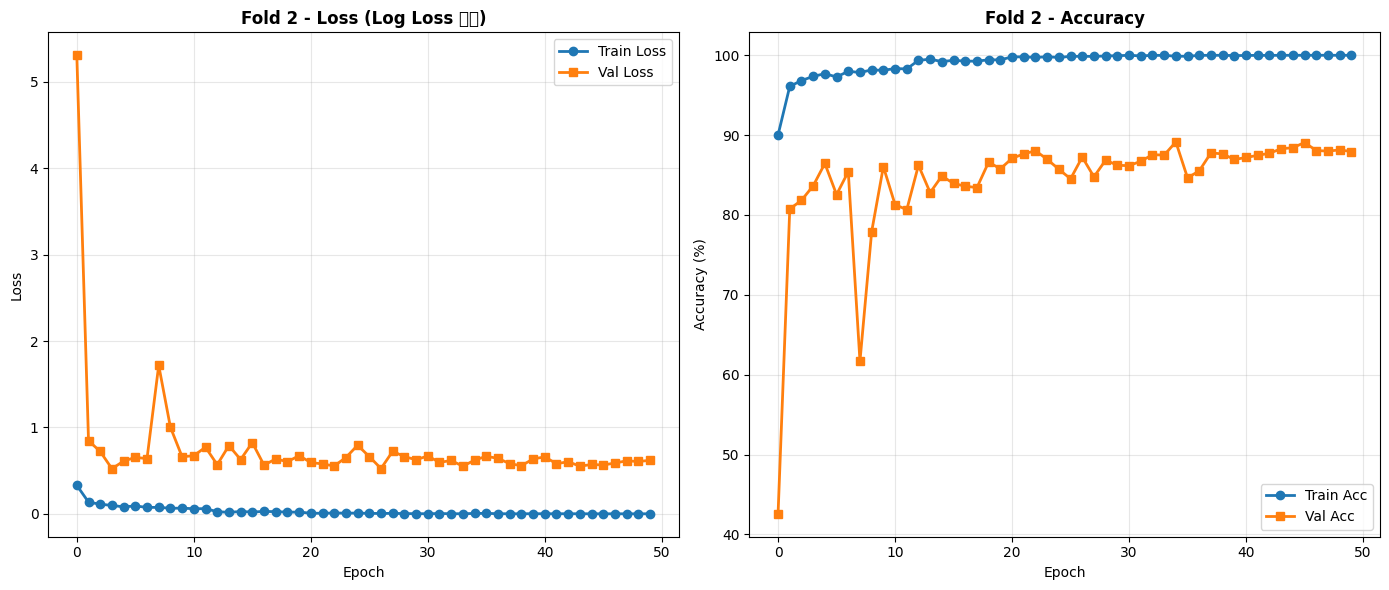

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # 1행 2열로 조정 (단일 폴드이므로)

for result in all_fold_results:
    fold_idx = result['fold']
    history = result['history']
    
    # Loss 그래프
    ax1 = axes[0]
    ax1.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    ax1.plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    ax1.set_title(f'Fold {fold_idx} - Loss (Log Loss 기준)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy 그래프
    ax2 = axes[1]
    ax2.plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
    ax2.plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
    ax2.set_title(f'Fold {fold_idx} - Accuracy', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./plots/loss_curve/inception_v{version}.png', dpi=300, bbox_inches='tight') # 파일명 수정
plt.show()

# Submission

In [ ]:
# 학습 결과에서 Fold 2의 정보를 추출합니다.
# all_fold_results에는 현재 단 하나의 결과(Fold 2)만 들어있어야 합니다.
if not all_fold_results:
    print("🚨 오류: 학습된 폴드 결과가 없습니다. train_fold 함수를 먼저 실행하세요.")
else:
    result = all_fold_results[0]
    fold_idx = result['fold']
    model_path = result['model_path']
    
    print("\n" + "=" * 70)
    print(f"🔮 Fold {fold_idx} 단일 모델 예측 시작")
    print("=" * 70)

    # 테스트 데이터셋 생성
    # test_dir은 'data/imgs/test'여야 합니다. 
    
    test_dataset = DriverDataset(
        test_dir, driver_df, [], 
        transform=team_transform_eval, is_test=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    print(f"테스트 샘플: {len(test_dataset)}개")

    # --- 모델 로드 및 예측 ---
    
    # 1. 모델 구조 생성 (pretrained=False)
    model = timm.create_model('inception_v4', pretrained=False, num_classes=num_classes)
    
    # 2. 저장된 최저 Loss 가중치 로드
    print(f"\n📁 모델 로드 중: {model_path}...")
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Fold {fold_idx} 모델 (Epoch {checkpoint['epoch']+1}, Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}) 로드 완료.")
    except Exception as e:
        print(f"🚨 모델 로드 실패: {e}")
        # 이 시점에서 코드 실행을 멈추거나, 오류 처리를 진행할 수 있습니다.
        raise
        
    model = model.to(device)
    model.eval() # 평가 모드 설정
    
    # 3. 예측 실행
    predictions = []
    img_names = []
    
    with torch.no_grad():
        for images, filenames in tqdm(test_loader, desc=f'Fold {fold_idx} 예측'):
            images = images.to(device)
            outputs = model(images)
            
            # 4. 확률 (Softmax) 계산
            probs = torch.softmax(outputs, dim=1)
            predictions.append(probs.cpu().numpy())
            
            img_names.extend(filenames)
    
    final_predictions = np.vstack(predictions)
    print(f"\n✓ 예측 완료: {final_predictions.shape}")

    # --- Submission 파일 생성 ---
    
    # 클래스 이름을 c0, c1, ... c9로 설정
    class_cols = [f'c{i}' for i in range(num_classes)]

    submission_data = {'img': img_names}
    for i, col in enumerate(class_cols):
        submission_data[col] = final_predictions[:, i]
    
    submission = pd.DataFrame(submission_data)

    submission_file = f'inception_v{version}.csv'
    submission.to_csv("./submissions/"+submission_file, index=False)

    print("\n" + "=" * 70)
    print(f"✅ Submission 파일 생성 완료: {submission_file}")
    print(f"✅ 총 {len(submission)}개 이미지 예측")
    print("=" * 70)
    
    print("\n📋 Submission 샘플:")
    print(submission.head())


🔮 Fold 2 단일 모델 예측 시작
테스트, 데이터 79726개 이미지
테스트 샘플: 79726개

📁 모델 로드 중: best_inception_v4_fold2.pth...
✓ Fold 2 모델 (Epoch 4, Val Loss: 0.5230) 로드 완료.


Fold 2 예측: 100%|██████████| 2492/2492 [21:59<00:00,  1.89it/s]



✓ 예측 완료: (79726, 10)

✅ Submission 파일 생성 완료: inception_v4_fold2_single_model_submission.csv
✅ 총 79726개 이미지 예측

📋 Submission 샘플:
              img            c0        c1            c2            c3  \
0       img_1.jpg  4.878655e-06  0.000002  5.649306e-05  8.250891e-06   
1      img_10.jpg  3.460569e-04  0.000054  1.523180e-04  3.451189e-04   
2     img_100.jpg  3.217587e-02  0.066979  3.252032e-03  1.057807e-01   
3    img_1000.jpg  2.382241e-07  0.000002  7.378043e-08  1.456193e-08   
4  img_100000.jpg  1.891374e-03  0.000804  1.817400e-03  9.341518e-01   

             c4            c5        c6            c7        c8        c9  
0  3.761202e-06  9.989375e-01  0.000130  7.514059e-04  0.000085  0.000022  
1  3.749123e-05  9.983867e-01  0.000269  3.655562e-05  0.000341  0.000032  
2  1.030610e-01  1.033657e-02  0.021122  4.900034e-02  0.397390  0.210902  
3  6.498618e-08  9.622739e-09  0.000006  4.300710e-08  0.998222  0.001769  
4  7.034020e-03  8.308074e-05  0.013749  2.803296e-0

# Analysis

운전자5명, 데이터 4006개 이미지


예측 중: 100%|██████████| 126/126 [01:00<00:00,  2.08it/s]


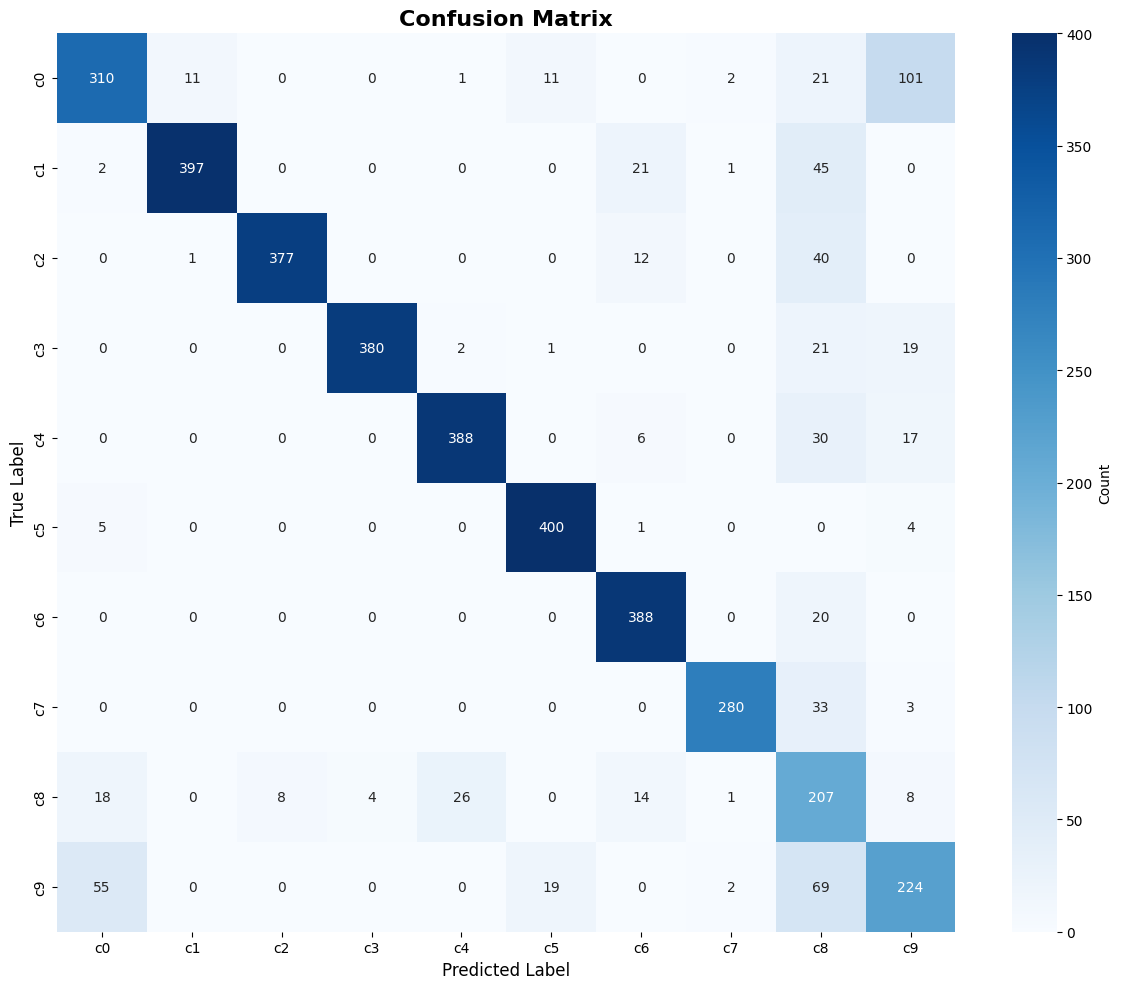

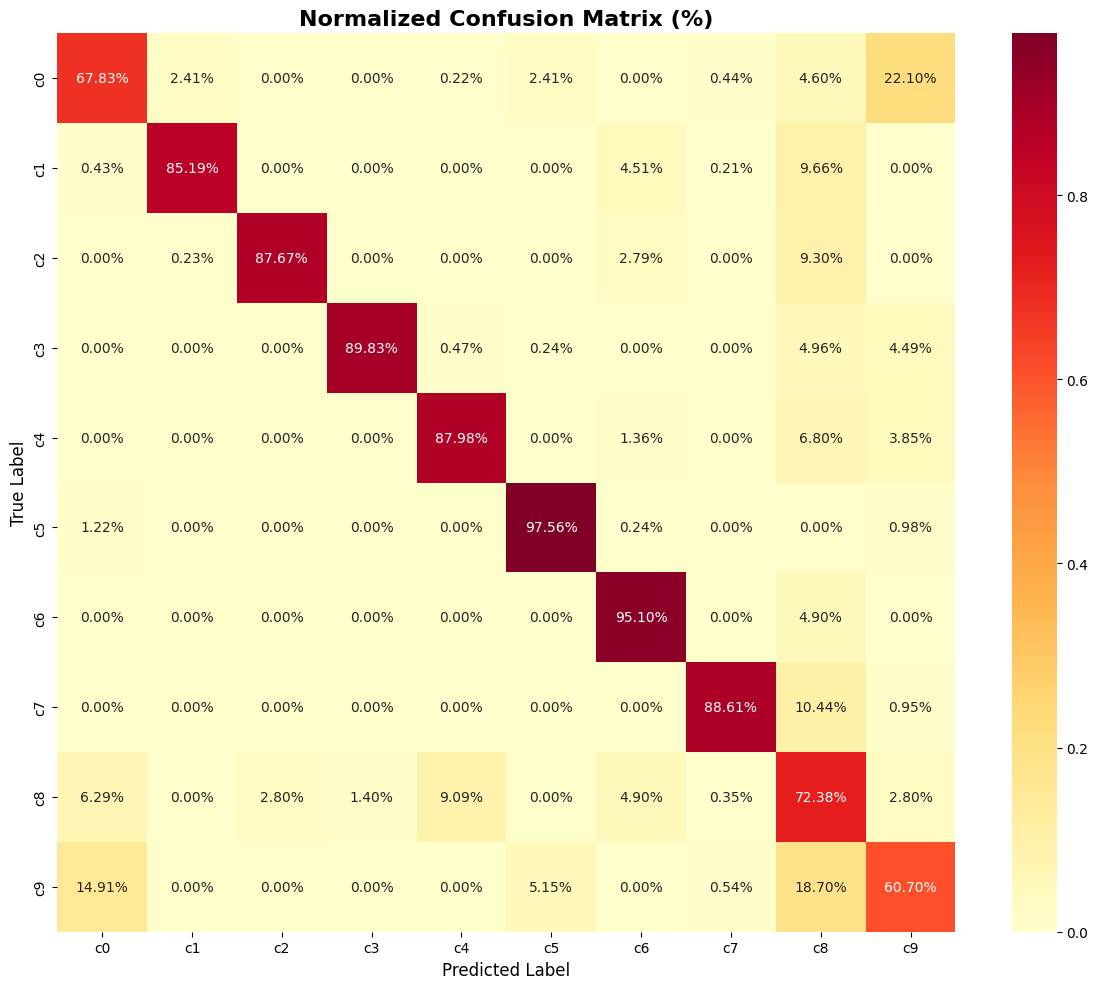


📊 Classification Report
              precision    recall  f1-score   support

          c0     0.7949    0.6783    0.7320       457
          c1     0.9707    0.8519    0.9074       466
          c2     0.9792    0.8767    0.9252       430
          c3     0.9896    0.8983    0.9418       423
          c4     0.9305    0.8798    0.9044       441
          c5     0.9281    0.9756    0.9512       410
          c6     0.8778    0.9510    0.9129       408
          c7     0.9790    0.8861    0.9302       316
          c8     0.4259    0.7238    0.5363       286
          c9     0.5957    0.6070    0.6013       369

    accuracy                         0.8365      4006
   macro avg     0.8471    0.8329    0.8343      4006
weighted avg     0.8625    0.8365    0.8448      4006



In [ ]:
# 셀 추가: Confusion Matrix 분석
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



def analyze_predictions(model, val_loader, device):
    """검증 데이터로 상세 분석"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='예측 중'):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    all_probs = np.vstack(all_probs)
    return np.array(all_labels), np.array(all_preds), all_probs

# 모델 로드
checkpoint = torch.load(best_model_path, map_location=device)
model = timm.create_model(
    'inception_v4',
    pretrained=True,
    num_classes = num_classes
)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

# 예측
fold_info = fold_splits[1] 

fold_idx = fold_info['fold']
train_drivers = fold_info['train_drivers']
val_drivers = fold_info['val_drivers']

val_dataset = DriverDataset(
    train_dir, driver_df, val_drivers,
    transform=team_transform_eval, is_test=False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)
y_true, y_pred, y_probs = analyze_predictions(model, val_loader, device)

# 1. Confusion Matrix
class_names = [f'c{i}' for i in range(10)]
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# 2. Normalized Confusion Matrix (비율)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix (%)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(f'plots/inception_v{version}/confusion_matrix_normalized.png', dpi=300)
plt.show()

# 3. Classification Report
print("\n" + "="*70)
print("📊 Classification Report")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


📈 클래스별 성능
Class  Precision   Recall  F1-Score  Support  Accuracy
   c0   0.794872 0.678337  0.731995      457  0.678337
   c1   0.970660 0.851931  0.907429      466  0.851931
   c2   0.979221 0.876744  0.925153      430  0.876744
   c3   0.989583 0.898345  0.941760      423  0.898345
   c4   0.930456 0.879819  0.904429      441  0.879819
   c5   0.928074 0.975610  0.951249      410  0.975610
   c6   0.877828 0.950980  0.912941      408  0.950980
   c7   0.979021 0.886076  0.930233      316  0.886076
   c8   0.425926 0.723776  0.536269      286  0.723776
   c9   0.595745 0.607046  0.601342      369  0.607046


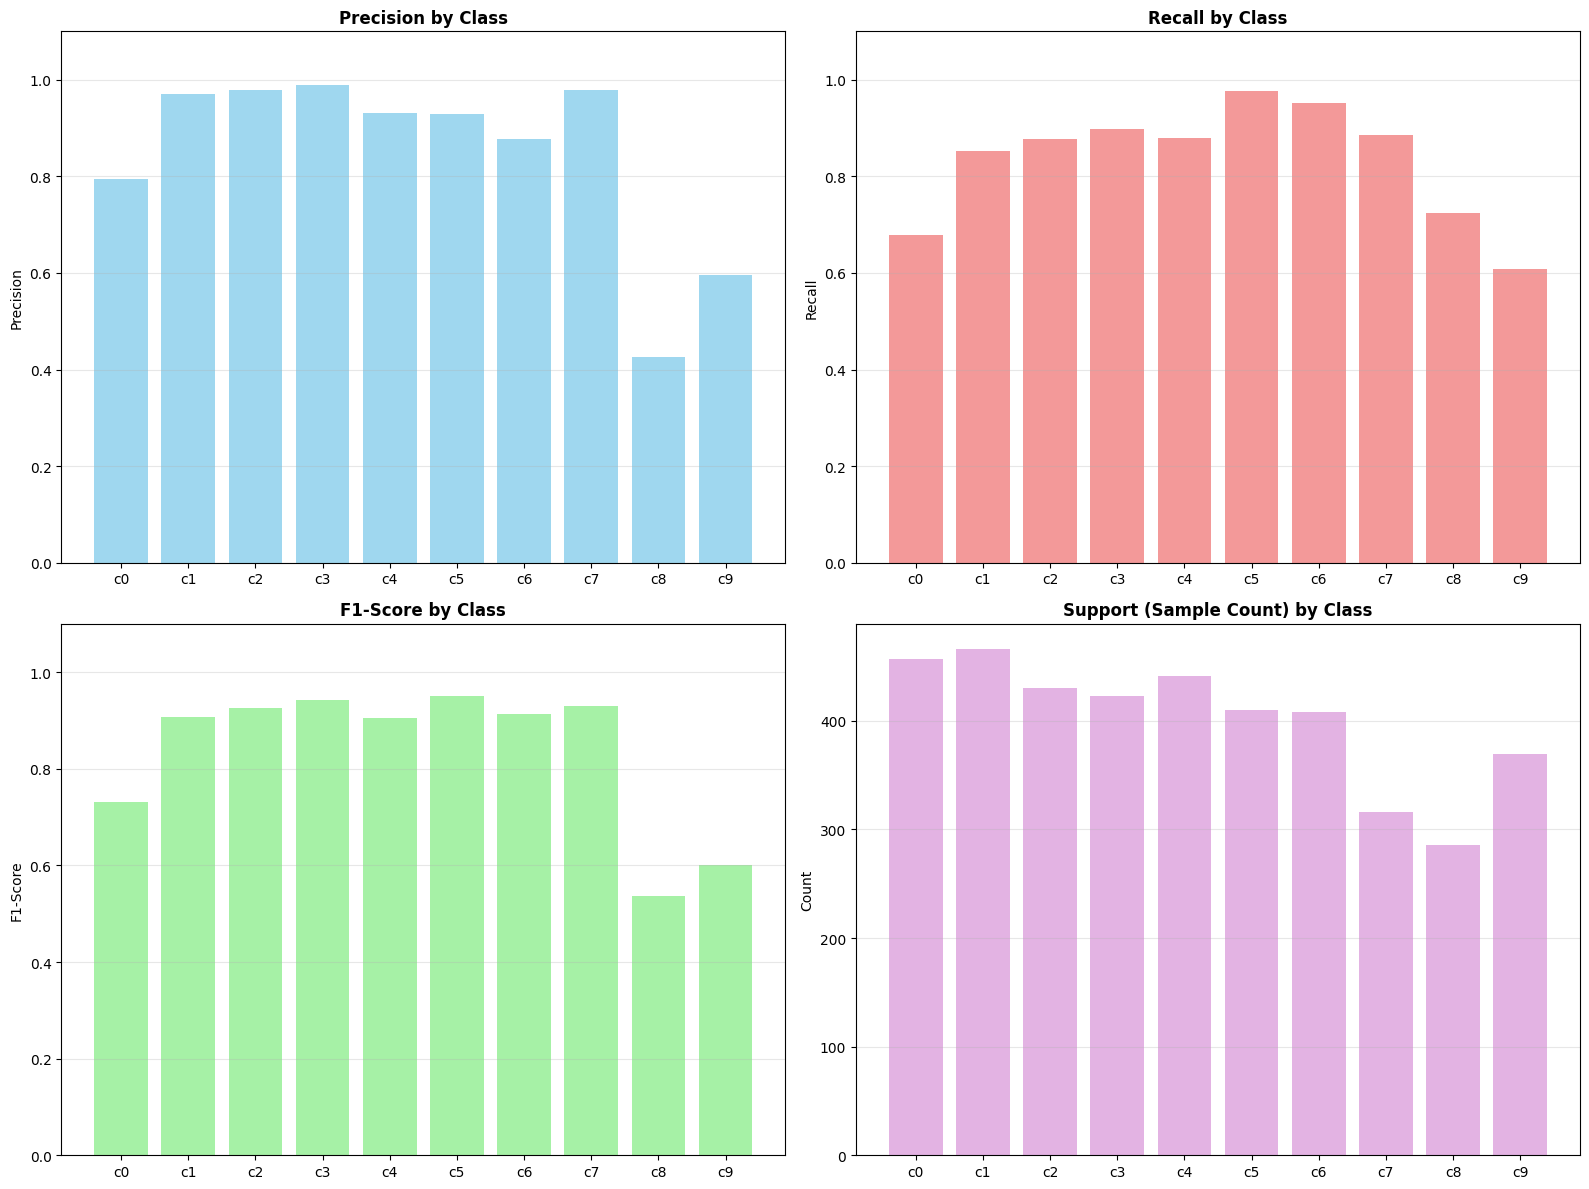

In [ ]:
# 클래스별 성능 분석
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None
)

# 데이터프레임으로 정리
class_performance = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support,
    'Accuracy': [accuracy_score(y_true[y_true==i], y_pred[y_true==i]) 
                 if np.sum(y_true==i) > 0 else 0 for i in range(10)]
})

print("\n" + "="*70)
print("📈 클래스별 성능")
print("="*70)
print(class_performance.to_string(index=False))

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Precision
axes[0, 0].bar(class_names, precision, color='skyblue', alpha=0.8)
axes[0, 0].set_title('Precision by Class', fontweight='bold')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_ylim([0, 1.1])
axes[0, 0].grid(axis='y', alpha=0.3)

# Recall
axes[0, 1].bar(class_names, recall, color='lightcoral', alpha=0.8)
axes[0, 1].set_title('Recall by Class', fontweight='bold')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_ylim([0, 1.1])
axes[0, 1].grid(axis='y', alpha=0.3)

# F1-Score
axes[1, 0].bar(class_names, f1, color='lightgreen', alpha=0.8)
axes[1, 0].set_title('F1-Score by Class', fontweight='bold')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Support
axes[1, 1].bar(class_names, support, color='plum', alpha=0.8)
axes[1, 1].set_title('Support (Sample Count) by Class', fontweight='bold')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'plots/inception_v{version}/class_performance.png', dpi=300)
plt.show()

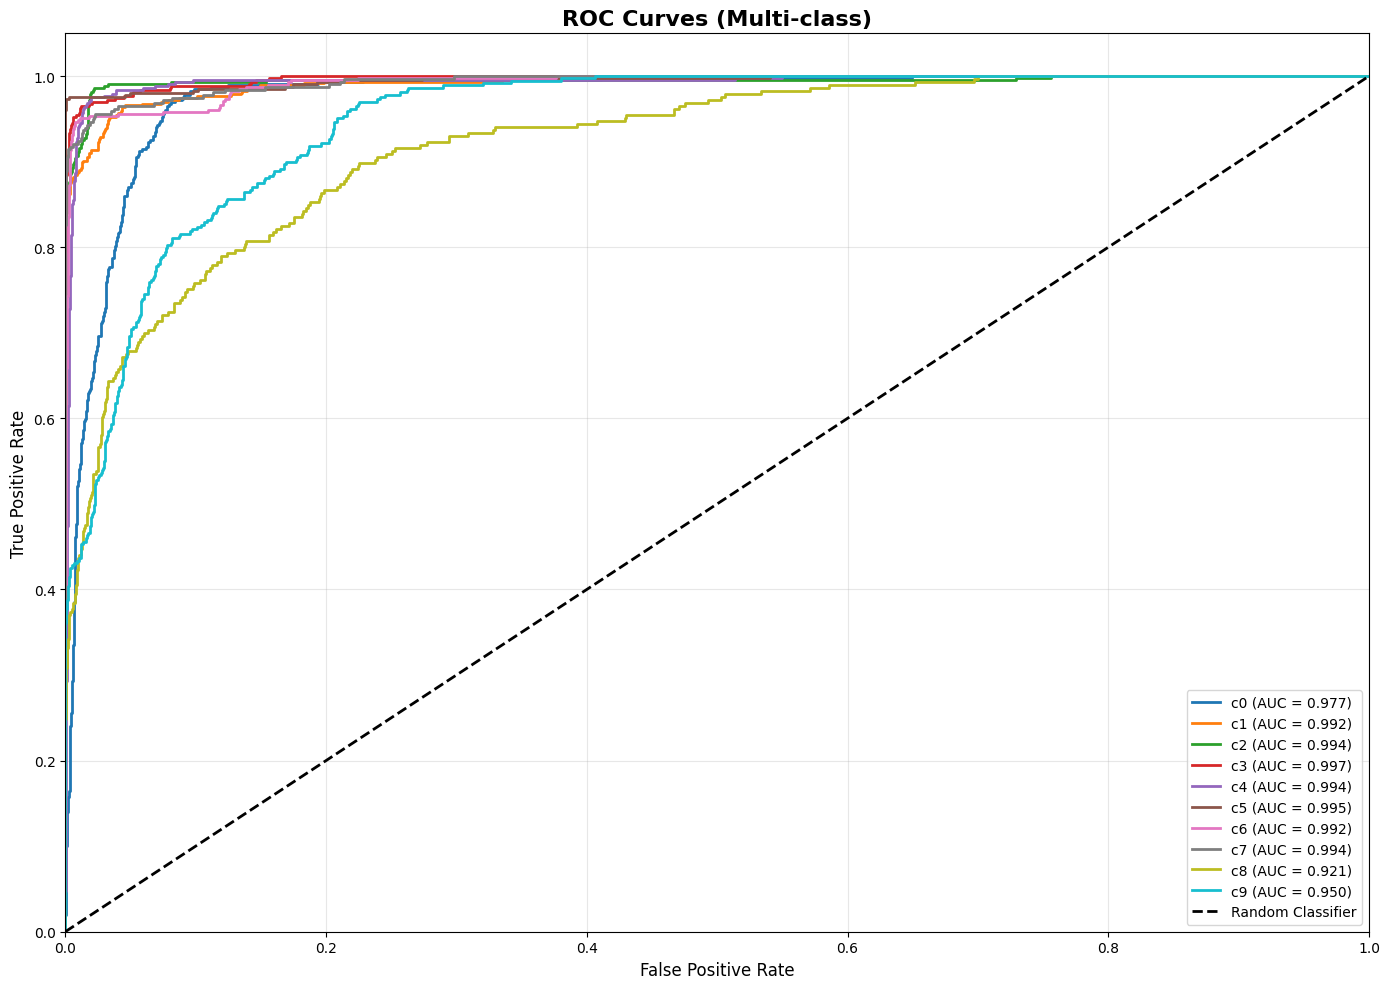

In [18]:
# ROC Curve 분석
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# One-hot encoding
y_true_bin = label_binarize(y_true, classes=range(10))

# 각 클래스별 ROC Curve
plt.figure(figsize=(14, 10))

for i in range(10):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves (Multi-class)', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'plots/inception_v{version}/roc_curves.png', dpi=300)
plt.show()


🔥 Grad-CAM 시각화

✅ 정답 예측 샘플


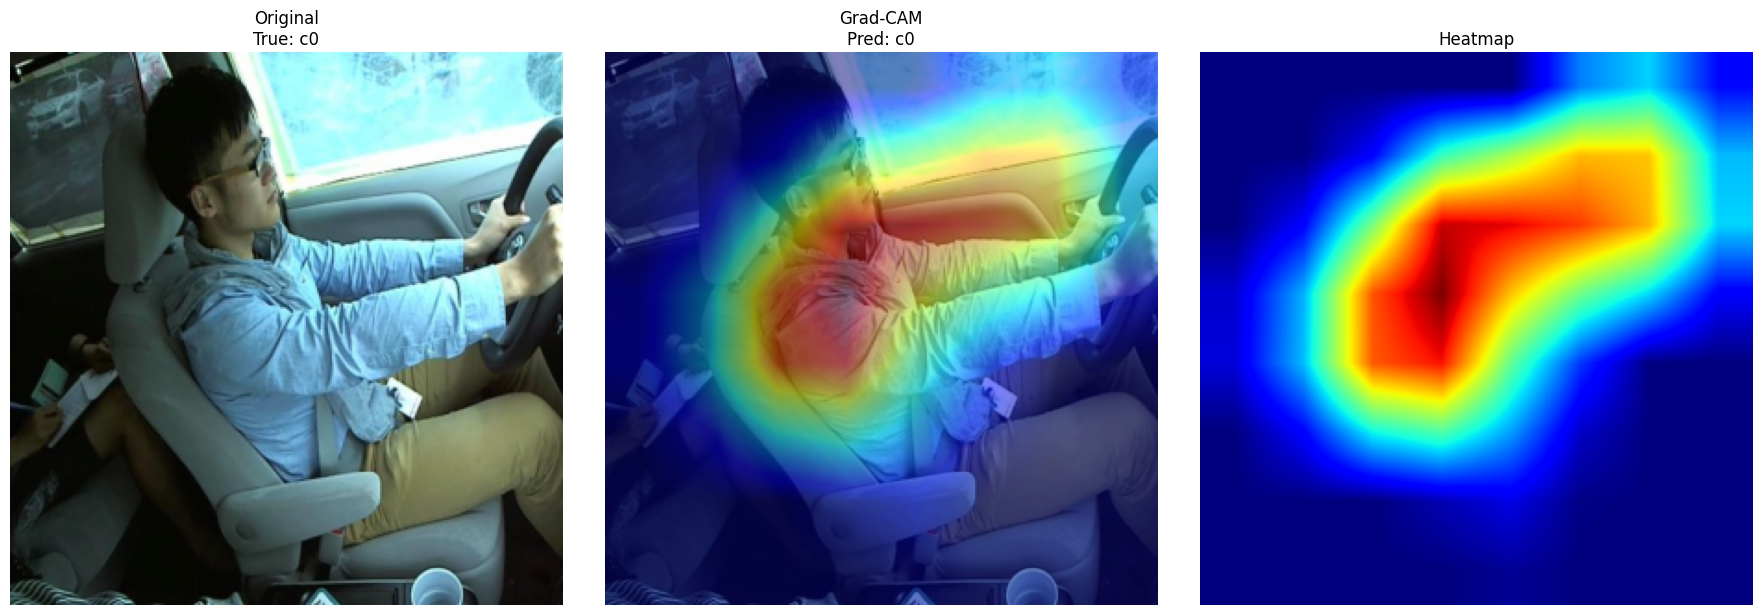

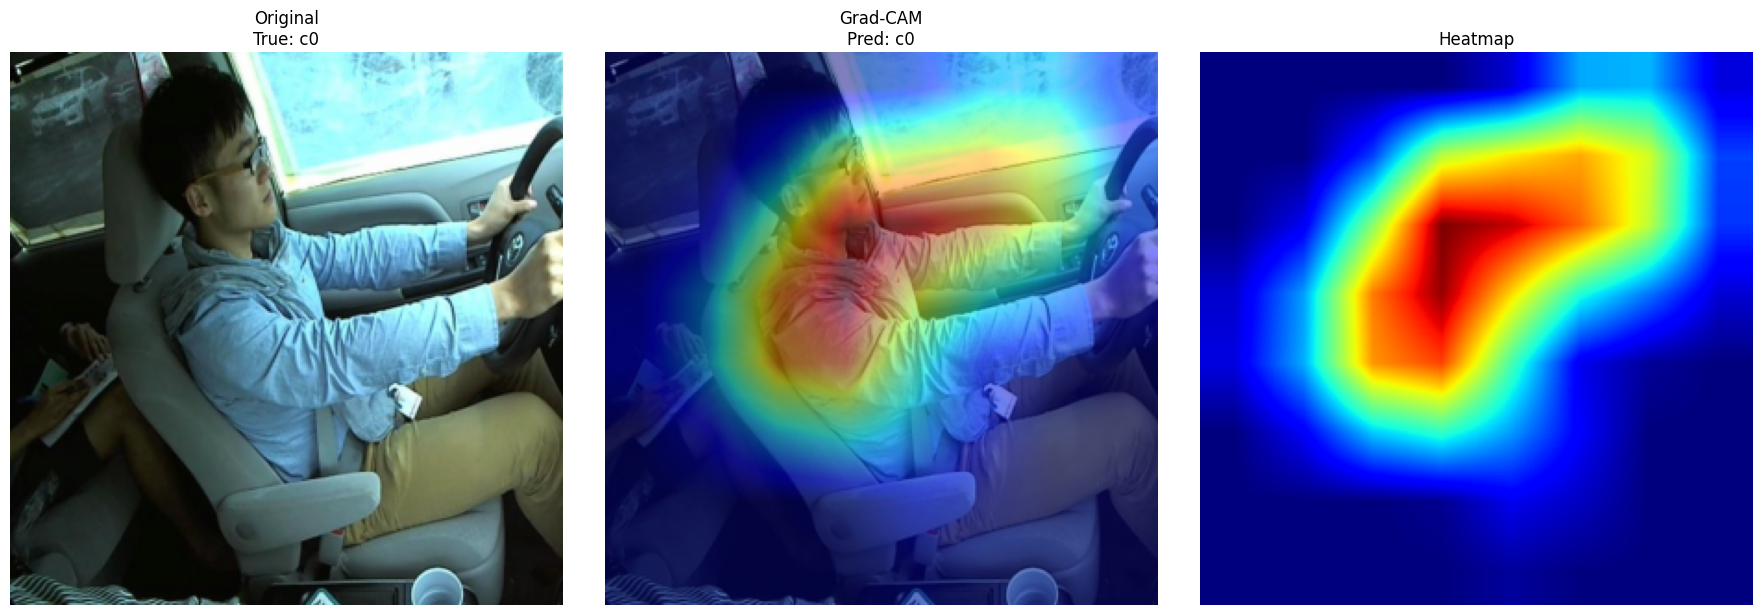

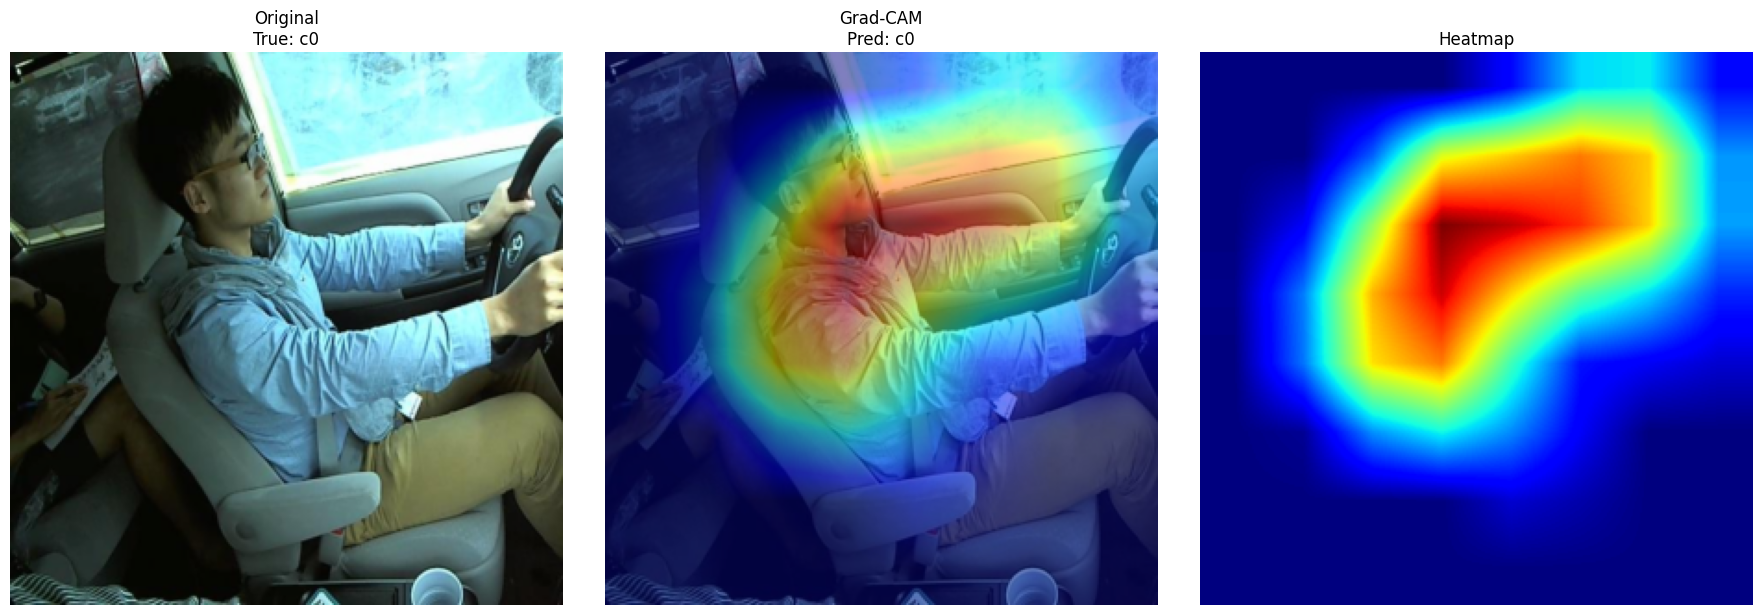


❌ 오답 예측 샘플


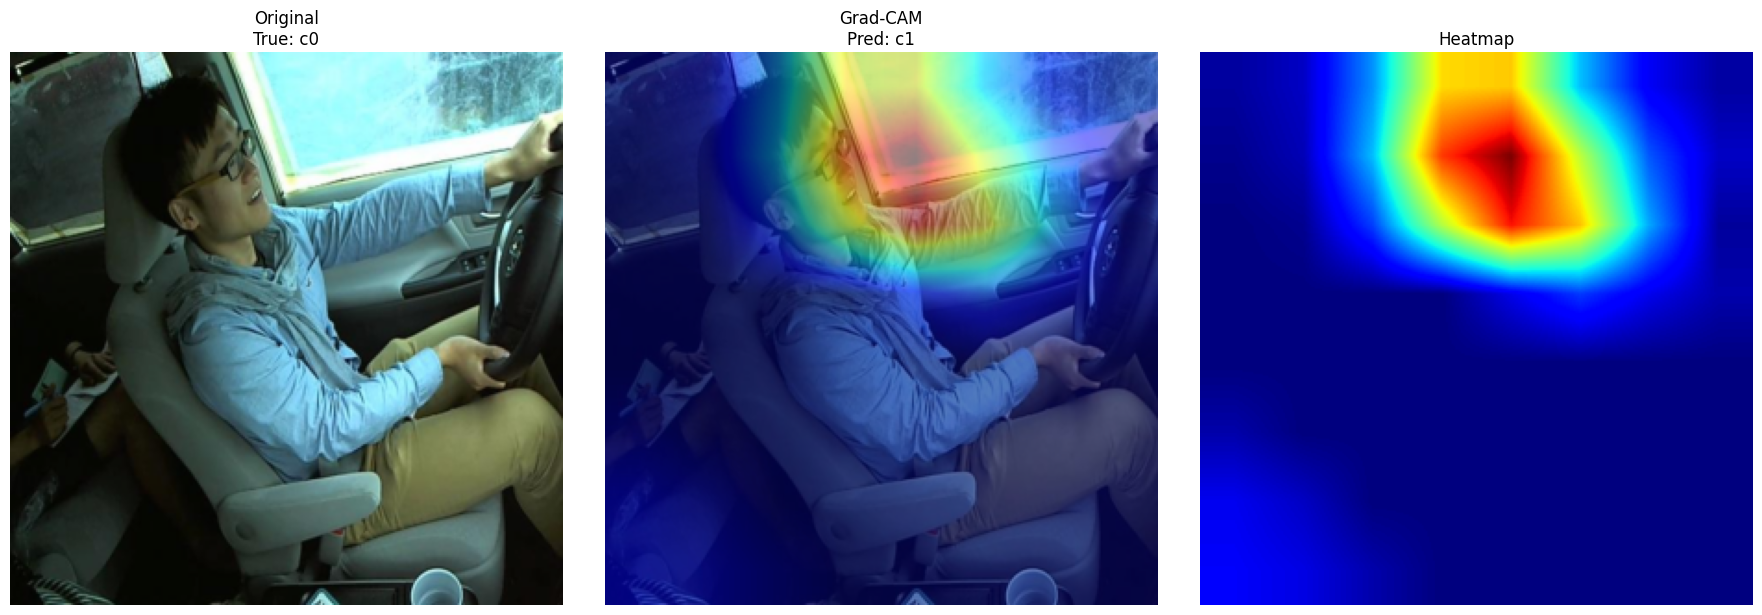

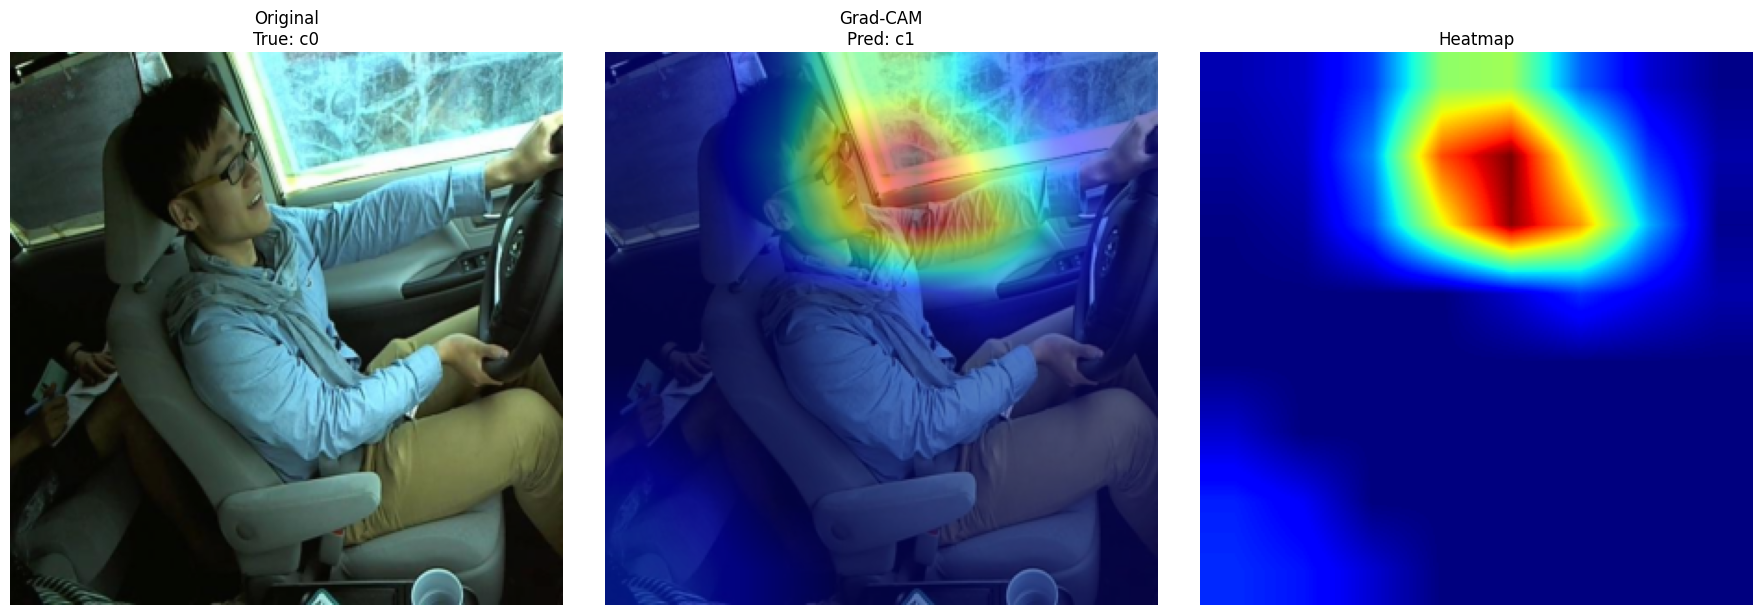

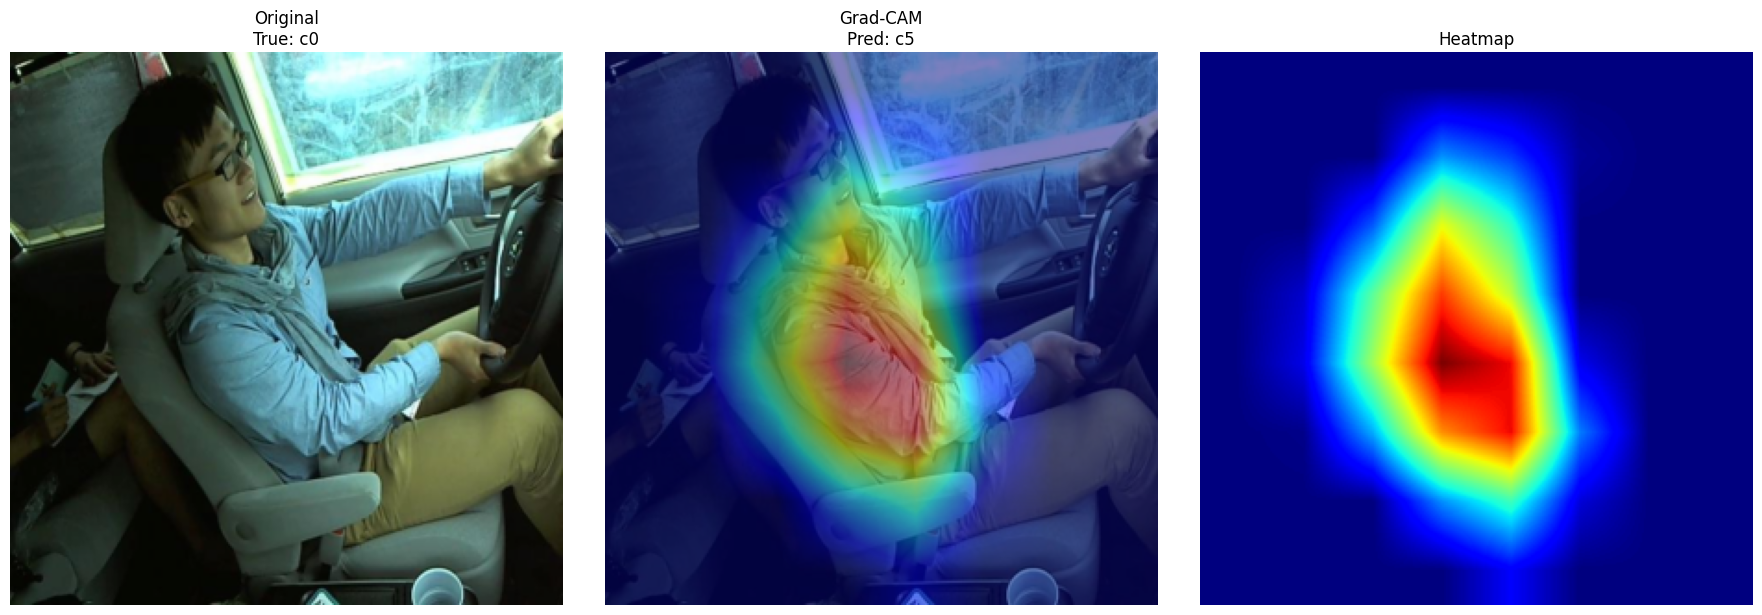

In [ ]:
# Grad-CAM 구현
import torch.nn.functional as F
from torchvision.transforms import ToPILImage

class GradCAM:
    """Grad-CAM for Inception V4"""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hook 등록
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        model_output = self.model(input_image)
        
        if target_class is None:
            target_class = model_output.argmax(dim=1)
        
        # Backward pass
        self.model.zero_grad()
        class_loss = model_output[0, target_class]
        class_loss.backward()
        
        # Grad-CAM 계산
        gradients = self.gradients[0].cpu()  # [C, H, W]
        activations = self.activations[0].cpu()  # [C, H, W]
        
        # Global Average Pooling on gradients
        weights = gradients.mean(dim=(1, 2), keepdim=True)  # [C, 1, 1]
        
        # Weighted combination
        cam = (weights * activations).sum(dim=0)  # [H, W]
        cam = F.relu(cam)  # ReLU
        cam = cam - cam.min()
        cam = cam / cam.max()  # Normalize to [0, 1]
        
        return cam.numpy(), model_output

# Inception V4의 마지막 Conv 레이어 찾기
def get_last_conv_layer(model):
    """Inception V4의 마지막 convolutional layer 찾기"""
    # Inception V4 구조: features -> last conv block
    # 일반적으로 'features'의 마지막 블록
    if hasattr(model, 'features'):
        return model.features[-1]
    else:
        # timm 모델의 경우 구조가 다를 수 있음
        # Mixed_7d가 마지막 Inception 블록
        for name, module in model.named_modules():
            if 'mixed_7d' in name.lower() or 'block8' in name.lower():
                return module
    return None

# Grad-CAM 적용
def visualize_gradcam(model, image, true_label, pred_label, device):
    """Grad-CAM 시각화"""
    # 마지막 Conv 레이어 가져오기
    target_layer = get_last_conv_layer(model)
    if target_layer is None:
        print("⚠️ 마지막 Conv 레이어를 찾을 수 없습니다.")
        return
    
    gradcam = GradCAM(model, target_layer)
    
    # Grad-CAM 생성
    image_tensor = image.unsqueeze(0).to(device)
    cam, output = gradcam.generate_cam(image_tensor, target_class=pred_label)
    
    # 원본 이미지 복원
    img_np = image.cpu().numpy().transpose(1, 2, 0)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    
    # CAM 리사이즈
    cam_resized = np.array(Image.fromarray(cam).resize((299, 299), Image.BILINEAR))
    
    # 시각화
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 원본 이미지
    axes[0].imshow(img_np)
    axes[0].set_title(f'Original\nTrue: c{true_label}', fontsize=12)
    axes[0].axis('off')
    
    # Grad-CAM
    axes[1].imshow(img_np)
    axes[1].imshow(cam_resized, cmap='jet', alpha=0.5)
    axes[1].set_title(f'Grad-CAM\nPred: c{pred_label}', fontsize=12)
    axes[1].axis('off')
    
    # Heatmap only
    axes[2].imshow(cam_resized, cmap='jet')
    axes[2].set_title('Heatmap', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    return fig

# 샘플 이미지에 Grad-CAM 적용
print("\n" + "="*70)
print("🔥 Grad-CAM 시각화")
print("="*70)

model.eval()

# 검증 데이터에서 샘플 추출 (정답/오답 각각)
correct_samples = []
incorrect_samples = []

for i, (images, labels) in enumerate(val_loader):
    if len(correct_samples) >= 3 and len(incorrect_samples) >= 3:
        break
    
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    for j in range(len(images)):
        if preds[j] == labels[j] and len(correct_samples) < 3:
            correct_samples.append((images[j], labels[j].item(), preds[j].item()))
        elif preds[j] != labels[j] and len(incorrect_samples) < 3:
            incorrect_samples.append((images[j], labels[j].item(), preds[j].item()))

# 정답 샘플 시각화
print("\n✅ 정답 예측 샘플")
for idx, (img, true_label, pred_label) in enumerate(correct_samples):
    fig = visualize_gradcam(model, img, true_label, pred_label, device)
    plt.savefig(f'plots/inception_v{version}/gradcam_correct_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 오답 샘플 시각화
print("\n❌ 오답 예측 샘플")
for idx, (img, true_label, pred_label) in enumerate(incorrect_samples):
    fig = visualize_gradcam(model, img, true_label, pred_label, device)
    plt.savefig(f'plots/inception_v{version}/gradcam_incorrect_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()


🔍 모델 구조 탐색
Conv Layer: features.0.conv
Conv Layer: features.1.conv
Conv Layer: features.2.conv
Conv Layer: features.3.conv.conv
Conv Layer: features.4.branch0.0.conv
Conv Layer: features.4.branch0.1.conv
Conv Layer: features.4.branch1.0.conv
Conv Layer: features.4.branch1.1.conv
Conv Layer: features.4.branch1.2.conv
Conv Layer: features.4.branch1.3.conv
Conv Layer: features.5.conv.conv
Conv Layer: features.6.branch0.conv
Conv Layer: features.6.branch1.0.conv
Conv Layer: features.6.branch1.1.conv
Conv Layer: features.6.branch2.0.conv
Conv Layer: features.6.branch2.1.conv
Conv Layer: features.6.branch2.2.conv
Conv Layer: features.6.branch3.1.conv
Conv Layer: features.7.branch0.conv
Conv Layer: features.7.branch1.0.conv
Conv Layer: features.7.branch1.1.conv
Conv Layer: features.7.branch2.0.conv
Conv Layer: features.7.branch2.1.conv
Conv Layer: features.7.branch2.2.conv
Conv Layer: features.7.branch3.1.conv
Conv Layer: features.8.branch0.conv
Conv Layer: features.8.branch1.0.conv
Conv Lay

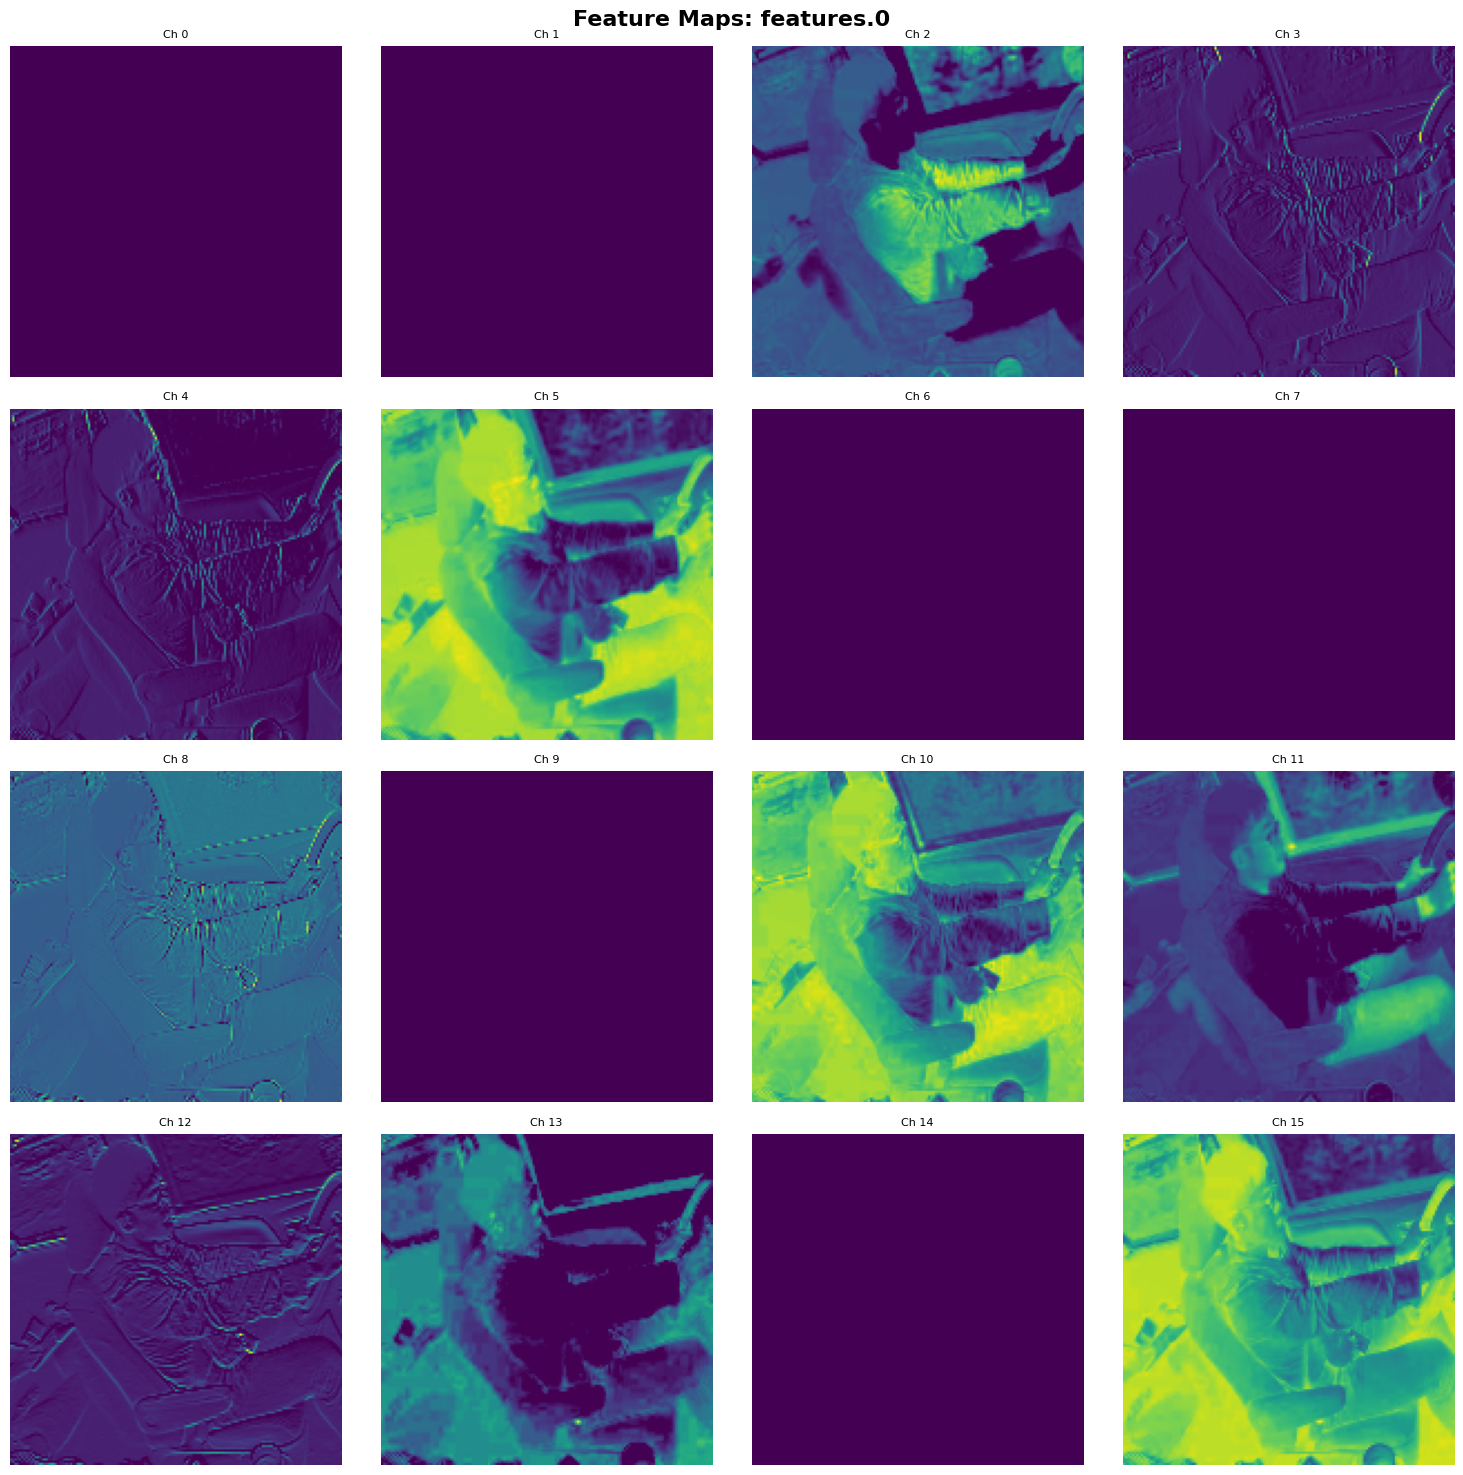

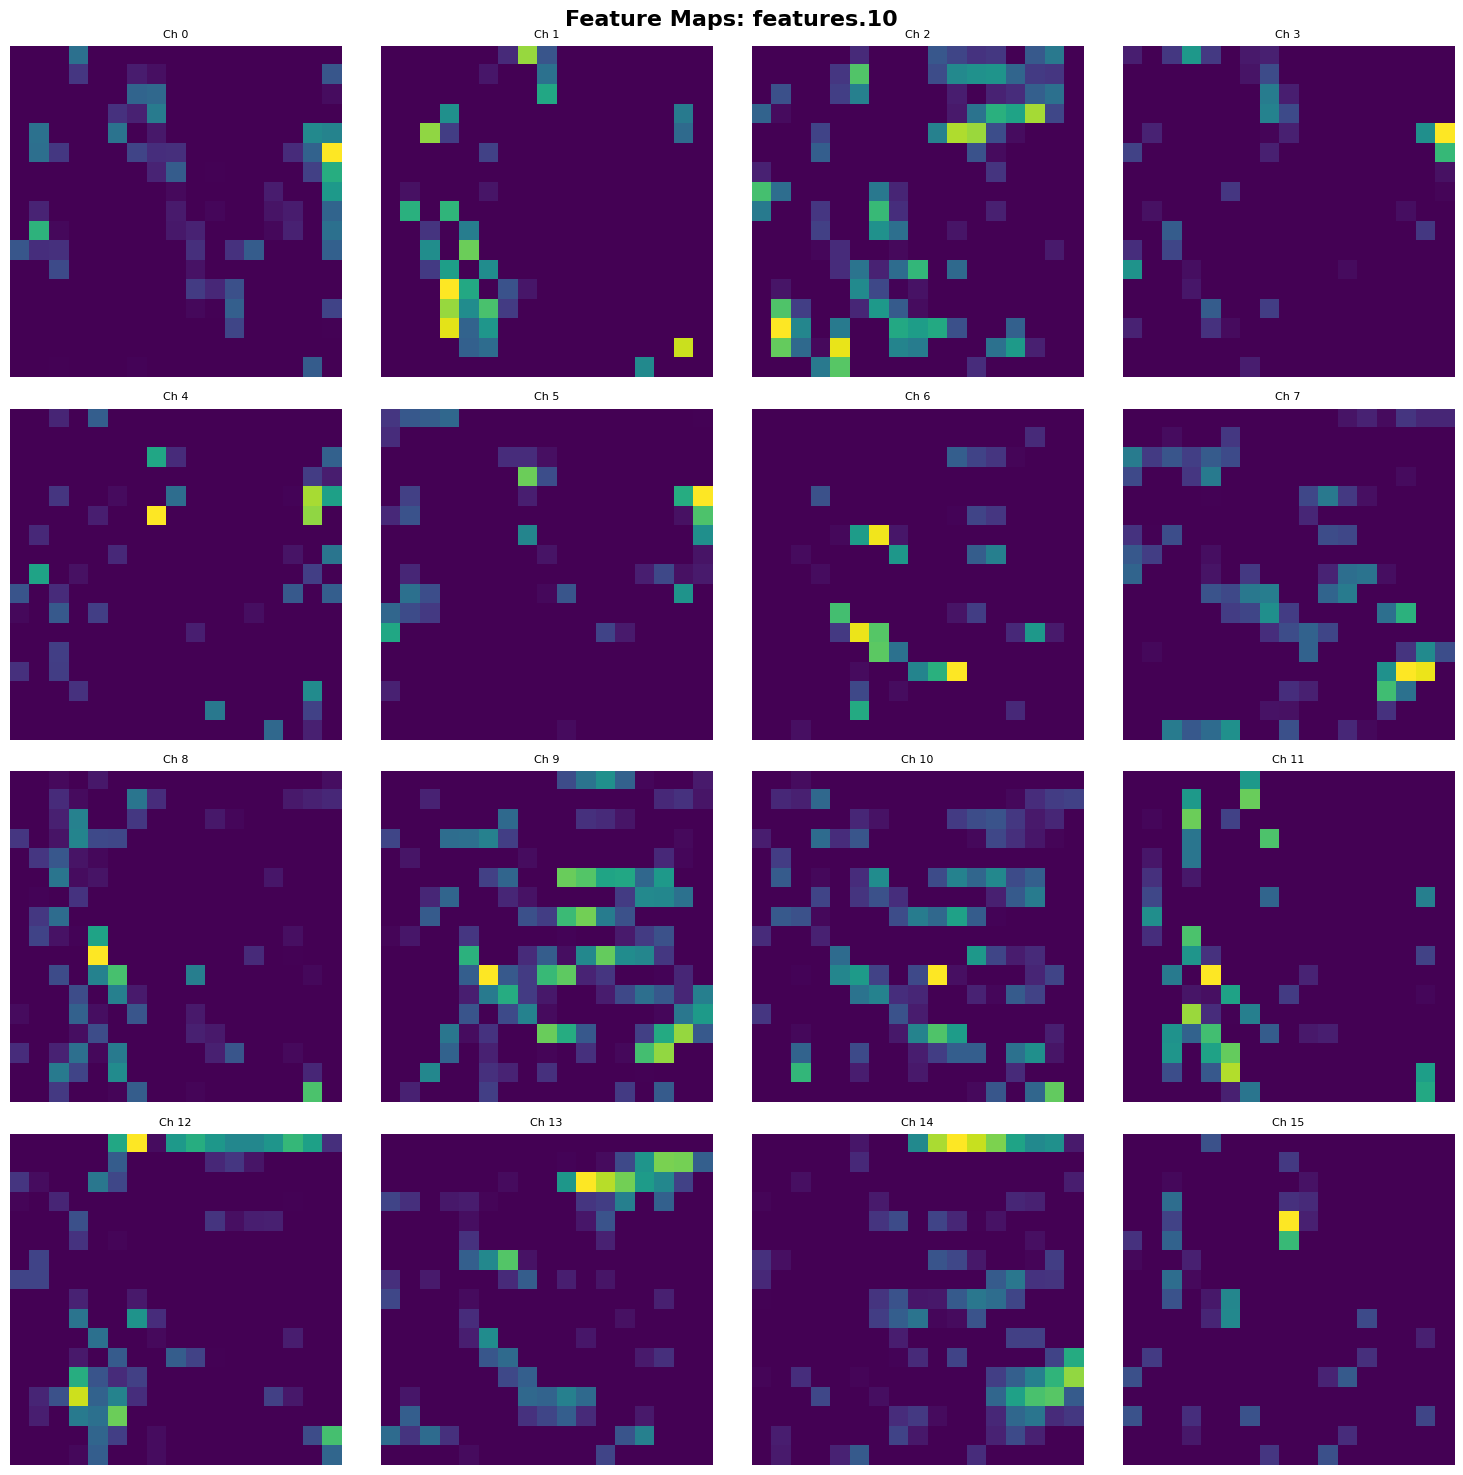

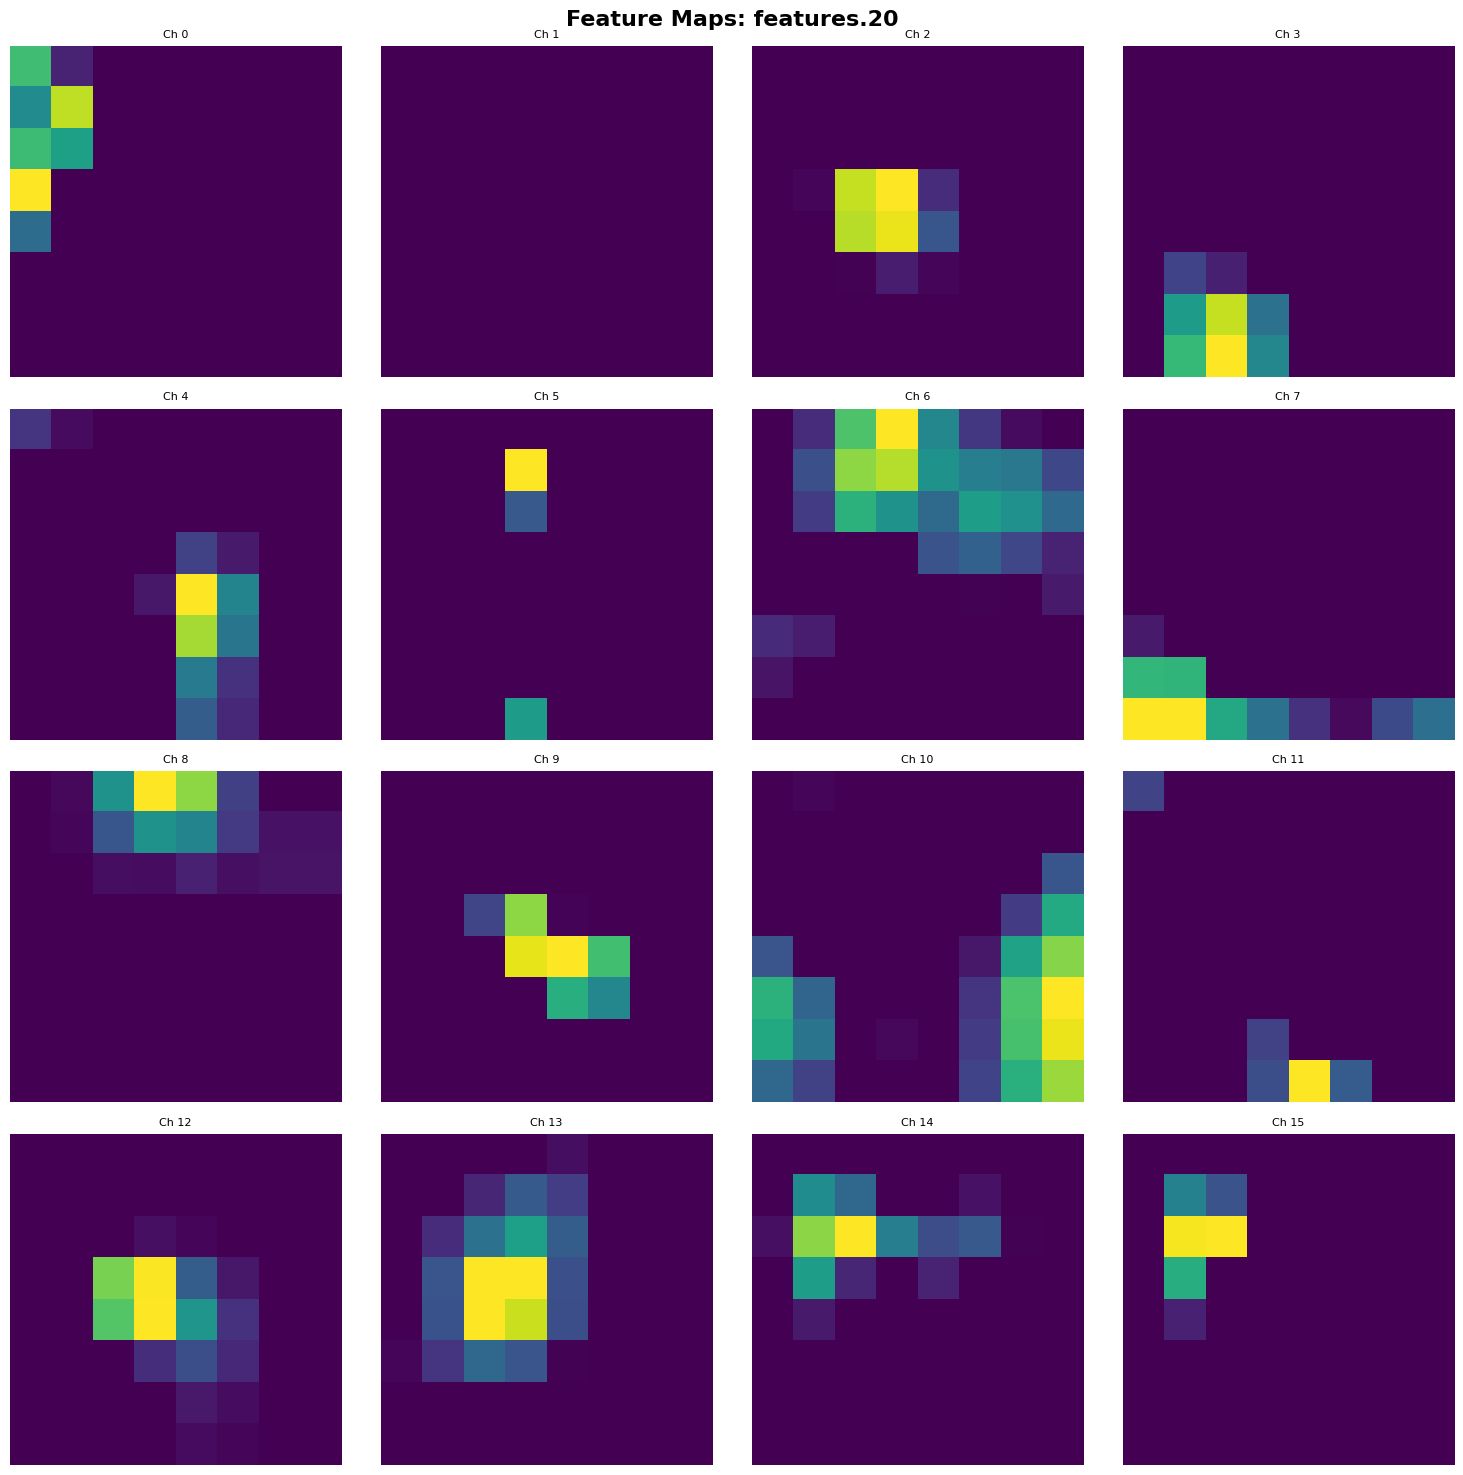

In [20]:
# Feature Map 추출 및 시각화
class FeatureExtractor:
    """중간 레이어의 Feature Map 추출"""
    
    def __init__(self, model, layer_names):
        self.model = model
        self.layer_names = layer_names
        self.features = {}
        
        # Hook 등록
        for name, layer in model.named_modules():
            if name in layer_names:
                layer.register_forward_hook(self.save_feature(name))
    
    def save_feature(self, name):
        def hook(module, input, output):
            self.features[name] = output.detach()
        return hook
    
    def extract(self, x):
        self.features = {}
        _ = self.model(x)
        return self.features

def visualize_feature_maps(features, layer_name, max_channels=16):
    """Feature Map 시각화"""
    feature = features[layer_name][0]  # 첫 번째 배치
    num_channels = min(feature.shape[0], max_channels)
    
    # Grid 크기 계산
    grid_size = int(np.ceil(np.sqrt(num_channels)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()
    
    for i in range(num_channels):
        fmap = feature[i].cpu().numpy()
        axes[i].imshow(fmap, cmap='viridis')
        axes[i].set_title(f'Ch {i}', fontsize=8)
        axes[i].axis('off')
    
    # 빈 subplot 숨기기
    for i in range(num_channels, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Feature Maps: {layer_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# Inception V4의 주요 레이어 이름 확인
print("\n" + "="*70)
print("🔍 모델 구조 탐색")
print("="*70)

for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        print(f"Conv Layer: {name}")

# 주요 레이어 선택 (예시)
target_layers = [
    'features.0',  # 첫 번째 Conv
    'features.10',  # 중간 블록
    'features.20',  # 후반 블록
]

# 샘플 이미지로 Feature Map 추출
sample_image, sample_label = next(iter(val_loader))
sample_image = sample_image[0:1].to(device)  # 첫 번째 이미지

extractor = FeatureExtractor(model, target_layers)
features = extractor.extract(sample_image)

# 각 레이어 시각화
for layer_name in target_layers:
    if layer_name in features:
        fig = visualize_feature_maps(features, layer_name, max_channels=16)
        plt.savefig(f'plots/inception_v{version}/feature_map_{layer_name.replace(".", "_")}.png', dpi=300)
        plt.show()


🧬 임베딩 추출 중...


임베딩 추출: 100%|██████████| 126/126 [01:04<00:00,  1.95it/s]


임베딩 shape: (4006, 1536)

📊 t-SNE 계산 중...


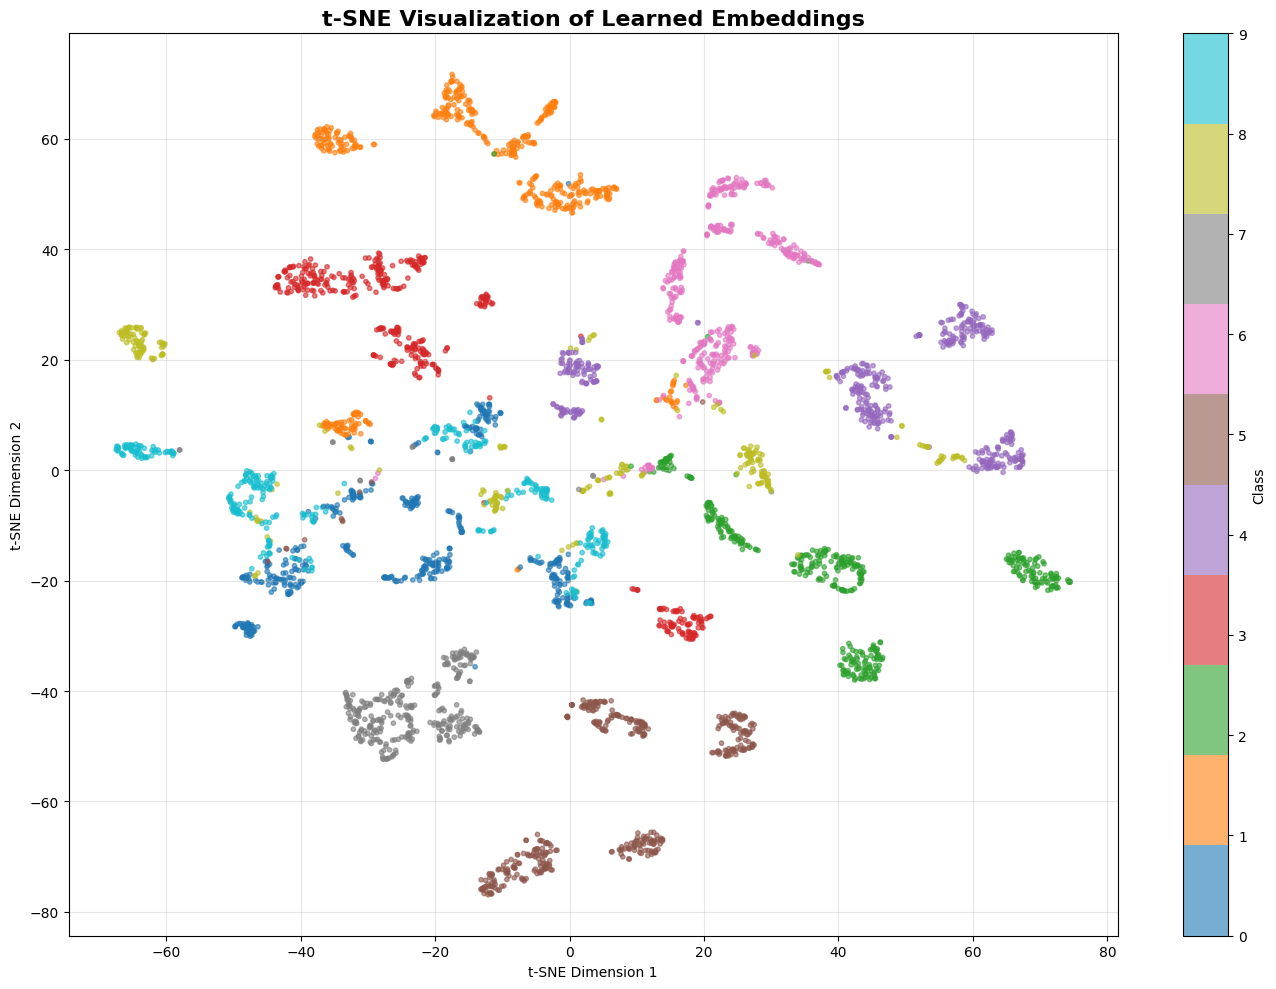

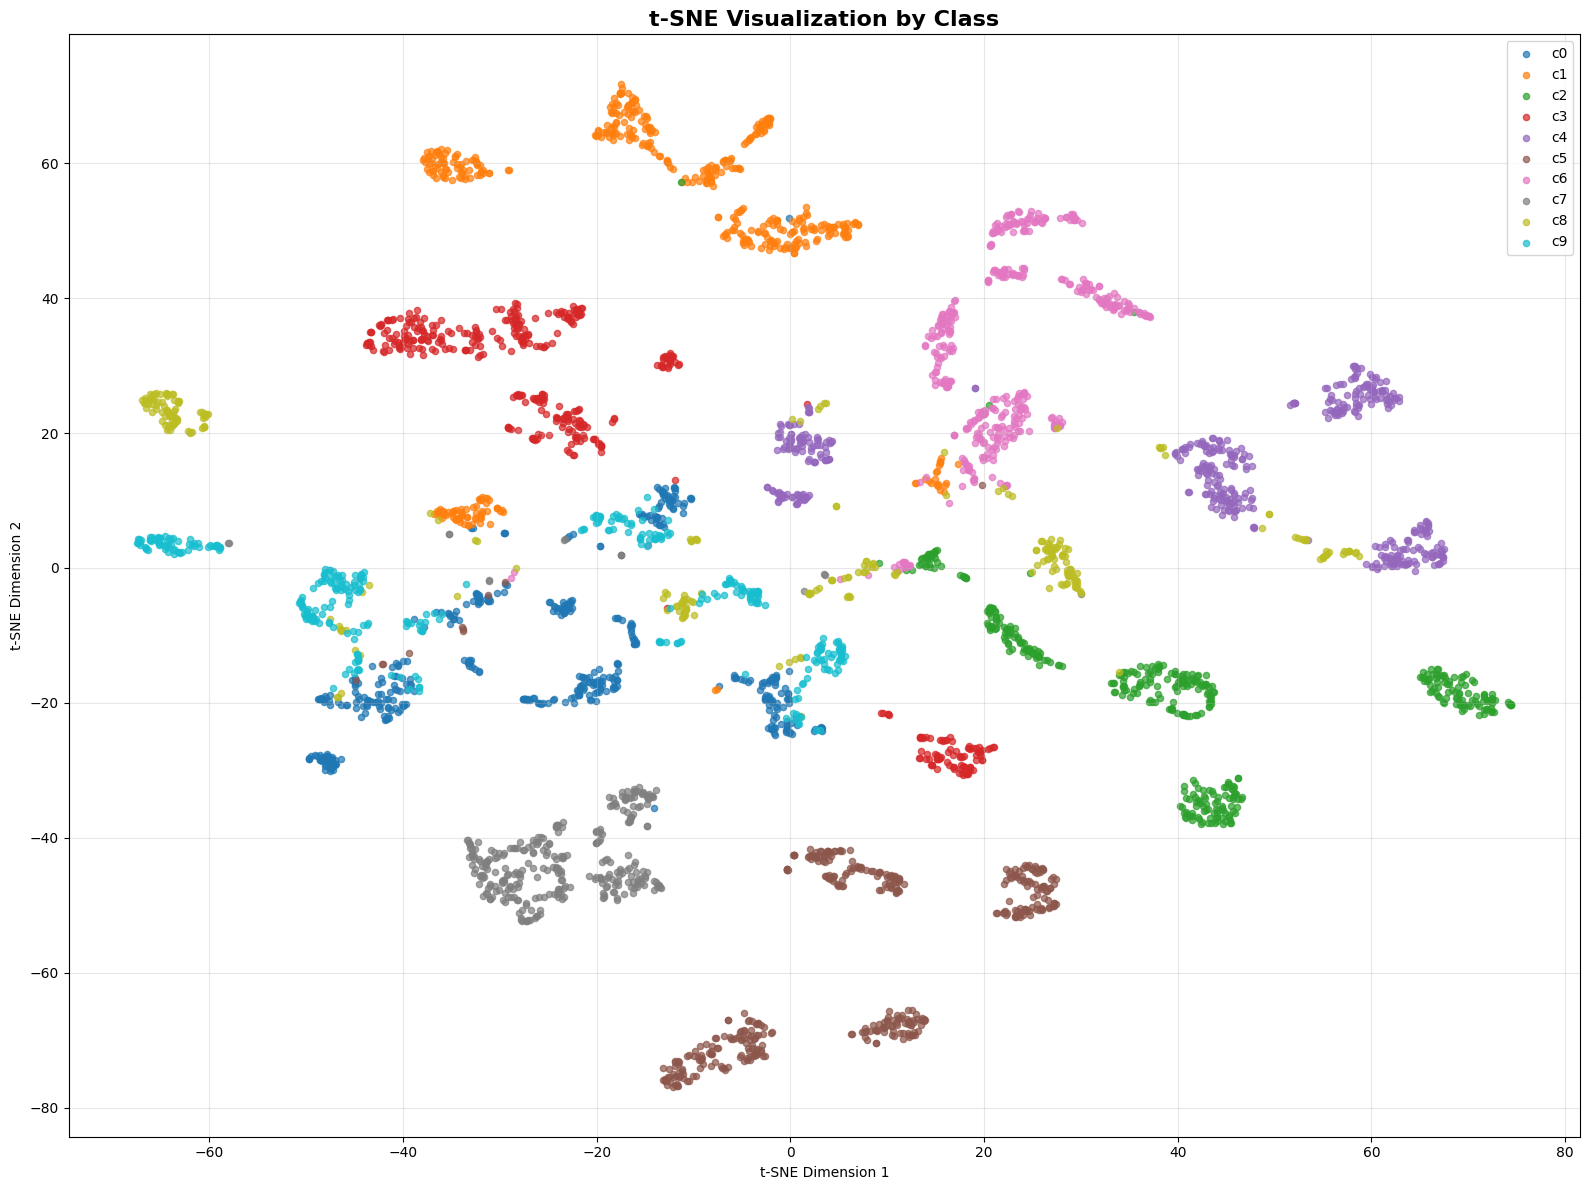

In [22]:
# t-SNE/UMAP으로 임베딩 시각화
from sklearn.manifold import TSNE
# pip install umap-learn
# from umap import UMAP

def extract_embeddings(model, dataloader, device):
    """마지막 FC 레이어 이전의 임베딩 추출"""
    model.eval()
    embeddings = []
    labels = []
    
    # FC 레이어 이전 출력 추출을 위한 Hook
    features = []
    def hook(module, input, output):
        features.append(input[0].detach())
    
    # Inception V4의 마지막 FC 레이어에 Hook
    if hasattr(model, 'last_linear'):
        handle = model.last_linear.register_forward_hook(hook)
    elif hasattr(model, 'fc'):
        handle = model.fc.register_forward_hook(hook)
    
    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc='임베딩 추출'):
            images = images.to(device)
            _ = model(images)
            
            embeddings.append(features[-1].cpu().numpy())
            labels.extend(lbls.numpy())
            features.clear()
    
    handle.remove()
    
    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    
    return embeddings, labels

# 임베딩 추출
print("\n" + "="*70)
print("🧬 임베딩 추출 중...")
print("="*70)

embeddings, labels = extract_embeddings(model, val_loader, device)
print(f"임베딩 shape: {embeddings.shape}")

# t-SNE 시각화
print("\n📊 t-SNE 계산 중...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1], 
    c=labels, 
    cmap='tab10', 
    s=10, 
    alpha=0.6
)
plt.colorbar(scatter, label='Class', ticks=range(10))
plt.title('t-SNE Visualization of Learned Embeddings', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'plots/inception_v{version}/tsne_embeddings.png', dpi=300)
plt.show()

# 클래스별로 색상 구분하여 Legend 추가
plt.figure(figsize=(16, 12))
for class_idx in range(10):
    mask = labels == class_idx
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        label=f'c{class_idx}',
        s=20,
        alpha=0.7
    )
plt.title('t-SNE Visualization by Class', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'plots/inception_v{version}/tsne_embeddings_by_class.png', dpi=300)
plt.show()